# Machine Learning's Capacity to Beat the Market -- Notebook
## Authors: Nathan Dejesus, Brandon Barker, Jack Lea, Mike Damiano, Ryan Schreck
---
The following notebook contains implemented machine learning algorithms to predict the open and close targets for the [New York Stock Exchange dataset](https://www.kaggle.com/datasets/dgawlik/nyse/data?select=fundamentals.csv). The makeup consists of **Preprocessing**, **Implementations**, and **Analysis** concerning the data's features. 

In [2]:
######PREPROCESSING######
import pandas as pd

# Load the datasets
fundamentals = pd.read_csv('data/fundamentals.csv')
prices = pd.read_csv('data/prices.csv')
#prices_split_adjusted = pd.read_csv('data/prices-split-adjusted.csv')
#securities = pd.read_csv('data/securities.csv')

# Display a few rows of each dataset to check the data
fundamentals_preview = fundamentals.head()
prices_preview = prices.head()
#prices_split_adjusted_preview = prices_split_adjusted.head()
#securities_preview = securities.head()

#print(fundamentals_preview, prices_preview, prices_split_adjusted_preview, securities_preview)
print('fundamental shape: ', fundamentals.shape)
print('price shape: ', prices.shape)


# Convert date columns to datetime format for easier alignment and filtering
fundamentals['Period Ending'] = pd.to_datetime(fundamentals['Period Ending'], errors='coerce')
prices['date'] = pd.to_datetime(prices['date'], format='ISO8601', errors='raise')

print('fundamental shape: ', fundamentals.shape)
print('price shape: ', prices.shape)


fundamental shape:  (1781, 79)
price shape:  (851264, 7)
fundamental shape:  (1781, 79)
price shape:  (851264, 7)


In [3]:
# Ensure the company symbols match across datasets
common_symbols = set(fundamentals['Ticker Symbol']).intersection(set(prices['symbol']))

# Filter the datasets for common symbols only
fundamentals_filtered = fundamentals[fundamentals['Ticker Symbol'].isin(common_symbols)]
prices_filtered = prices[prices['symbol'].isin(common_symbols)]
#prices_split_adjusted_filtered = prices_split_adjusted[prices_split_adjusted['symbol'].isin(common_symbols)]

# Remove rows with NaT values in the date columns to avoid the 'NaTType' normalization error
fundamentals_filtered = fundamentals_filtered.dropna(subset=['Period Ending'])
prices_filtered = prices_filtered.dropna(subset=['date'])

# Preview the filtered datasets to confirm alignment based on common symbols
fundamentals_filtered_preview = fundamentals_filtered.head()
prices_filtered_preview = prices_filtered.head()
#prices_split_adjusted_filtered_preview = prices_split_adjusted_filtered.head()

#print(fundamentals_filtered_preview, prices_filtered_preview, prices_split_adjusted_filtered_preview)
print('shape: ', fundamentals_filtered.shape)
print('shape: ', prices_filtered.shape)

shape:  (1777, 79)
shape:  (760913, 7)


In [4]:
# Resample the prices data to a quarterly basis
prices_quarterly = prices_filtered.set_index('date').groupby('symbol').resample('QE').agg({
    'open': 'mean',
    'close': 'mean',
    'low': 'mean',
    'high': 'mean',
    'volume': 'sum'
}).reset_index()

# Display the resampled quarterly prices data
#print(prices_quarterly)
print('shape: ', prices_quarterly.shape)
fundamentals_filtered.head()


shape:  (12097, 7)


Unnamed: 0 Ticker Symbol Period Ending  Accounts Payable  \
0           0           AAL    2012-12-31      3.068000e+09   
1           1           AAL    2013-12-31      4.975000e+09   
2           2           AAL    2014-12-31      4.668000e+09   
3           3           AAL    2015-12-31      5.102000e+09   
4           4           AAP    2012-12-29      2.409453e+09   

   Accounts Receivable  Add'l income/expense items  After Tax ROE  \
0         -222000000.0               -1.961000e+09           23.0   
1          -93000000.0               -2.723000e+09           67.0   
2         -160000000.0               -1.500000e+08          143.0   
3          352000000.0               -7.080000e+08          135.0   
4          -89482000.0                6.000000e+05           32.0   

   Capital Expenditures  Capital Surplus  Cash Ratio  ...  \
0         -1.888000e+09     4.695000e+09        53.0  ...   
1         -3.114000e+09     1.059200e+10        75.0  ...   
2         -5.311000e+09     1.513500e+10        60.0  ...   
3         -6.151000e+09     1.159100e+10        51.0  ...   
4         -2.711820e+08     5.202150e+08        23.0  ...   

   Total Current Assets  Total Current Liabilities  Total Equity  \
0          7.072000e+09               9.011000e+09 -7.987000e+09   
1          1.432300e+10               1.380600e+10 -2.731000e+09   
2          1.175000e+10               1.340400e+10  2.021000e+09   
3          9.985000e+09               1.360500e+10  5.635000e+09   
4          3.184200e+09               2.559638e+09  1.210694e+09   

   Total Liabilities  Total Liabilities & Equity  Total Revenue  \
0       2.489100e+10                1.690400e+10   2.485500e+10   
1       4.500900e+10                4.227800e+10   2.674300e+10   
2       4.120400e+10                4.322500e+10   4.265000e+10   
3       4.278000e+10                4.841500e+10   4.099000e+10   
4       3.403120e+09                4.613814e+09   6.205003e+09   

   Treasury Stock  For Year  Earnings Per Share  Estimated Shares Outstanding  
0    -367000000.0    2012.0               -5.60                  3.350000e+08  
1             0.0    2013.0              -11.25                  1.630222e+08  
2             0.0    2014.0                4.02                  7.169154e+08  
3             0.0    2015.0               11.39                  6.681299e+08  
4     -27095000.0    2012.0                5.29                  7.328355e+07  

[5 rows x 79 columns]

In [5]:
# Align fundamentals with prices data based on company symbols and nearest corresponding quarters
# Merge fundamentals and quarterly prices data on 'Ticker Symbol' and 'symbol' (company symbols) and the nearest quarter end dates

# Renaming 'Ticker Symbol' in fundamentals to match 'symbol' for merging
fundamentals_filtered = fundamentals_filtered.rename(columns={'Ticker Symbol': 'symbol'})

# Merging with nearest join on date within the same quarter period
aligned_data = pd.merge_asof(prices_quarterly.sort_values('date'), 
                             fundamentals_filtered.sort_values('Period Ending'), 
                             by='symbol', 
                             left_on='date', 
                             right_on='Period Ending', 
                             direction='backward')

# Display a preview of the aligned dataset
#print(aligned_data.head())
print('shape: ', aligned_data.shape)
print(aligned_data)


shape:  (12097, 85)
      symbol       date       open      close        low       high  \
0        AAL 2010-03-31   6.468361   6.494754   6.320820   6.663443   
1        HAR 2010-03-31  41.127705  41.262131  40.575901  41.760164   
2         KR 2010-03-31  21.514098  21.568361  21.355574  21.745738   
3       NTRS 2010-03-31  52.970984  53.009836  52.435737  53.504918   
4       VIAB 2010-03-31  30.260984  30.297869  29.902131  30.610983   
...      ...        ...        ...        ...        ...        ...   
12092    COG 2016-12-31  22.575238  22.487778  22.128571  22.934762   
12093   QCOM 2016-12-31  67.303333  67.181586  66.515079  67.940952   
12094    COL 2016-12-31  88.023492  88.146191  87.388413  88.725238   
12095    GIS 2016-12-31  61.947302  61.948095  61.512857  62.345555   
12096    ZTS 2016-12-31  50.953651  50.840317  50.394921  51.290159   

             volume  Unnamed: 0 Period Ending  Accounts Payable  ...  \
0      6.670161e+08         NaN           NaT          

In [6]:
aligned_data_cleaned = aligned_data.dropna()
aligned_data_cleaned = aligned_data_cleaned.drop(columns=['Unnamed: 0']) # drop the unnamed column
print('shape: ', aligned_data_cleaned.shape)
aligned_data_cleaned.head()

shape:  (5243, 84)


symbol       date       open      close        low       high  \
3769    BBY 2012-03-31  25.046290  25.079355  24.710968  25.405806   
3993    BBY 2012-06-30  20.450794  20.450476  20.103492  20.842857   
4473    BBY 2012-09-30  18.744921  18.659206  18.329206  19.058254   
4624    CXO 2012-12-31  85.449033  85.178387  84.151451  86.481613   
4628    GPC 2012-12-31  62.536774  62.532419  62.011129  63.064678   

           volume Period Ending  Accounts Payable  Accounts Receivable  ...  \
3769  384639000.0    2012-03-03      7.876000e+09           41000000.0  ...   
3993  568475600.0    2012-03-03      7.876000e+09           41000000.0  ...   
4473  602073500.0    2012-03-03      7.876000e+09           41000000.0  ...   
4624   61617200.0    2012-12-31      3.918140e+08          -23091000.0  ...   
4628   47447900.0    2012-12-31      2.237638e+09           13366000.0  ...   

      Total Current Assets  Total Current Liabilities  Total Equity  \
3769          1.029700e+10               8.855000e+09  3.745000e+09   
3993          1.029700e+10               8.855000e+09  3.745000e+09   
4473          1.029700e+10               8.855000e+09  3.745000e+09   
4624          4.588820e+08               7.400860e+08  3.466196e+09   
4628          4.820131e+09               2.487638e+09  2.997887e+09   

      Total Liabilities  Total Liabilities & Equity  Total Revenue  \
3769       1.226000e+10                1.600500e+10   4.545700e+10   
3993       1.226000e+10                1.600500e+10   4.545700e+10   
4473       1.226000e+10                1.600500e+10   4.545700e+10   
4624       5.123241e+09                8.589437e+09   1.819814e+09   
4628       3.809174e+09                6.807061e+09   1.301387e+10   

      Treasury Stock  For Year  Earnings Per Share  \
3769             0.0    2012.0               -3.36   
3993             0.0    2012.0               -3.36   
4473             0.0    2012.0               -3.36   
4624      -7186000.0    2012.0                4.18   
4628             0.0    2012.0                4.17   

      Estimated Shares Outstanding  
3769                  3.663690e+08  
3993                  3.663690e+08  
4473                  3.663690e+08  
4624                  1.032749e+08  
4628                  1.554055e+08  

[5 rows x 84 columns]

## Feature Selection
---
The following code implements feature selection techniques to identify the most relevant features for predicting stock prices. The techniques used include Recursive Feature Elimination (RFE) and Sequential Feature Selection (Forward Selection). The top 50 features are selected for each technique and the common features are identified. All correlated features are removed to avoid multicollinearity and the remaining features are used for model building.

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Display descriptive statistics for the cleaned dataset
# desc_stats = aligned_data_cleaned.describe()
# print(desc_stats)

# Calculate correlations for key financial metrics and stock prices
print_corr = aligned_data_cleaned.drop(columns=['symbol']).corr().unstack().sort_values(ascending=False)
# print(print_corr['open'])

# List number of features & features
print('Number of features: ', len(aligned_data_cleaned.columns))

# Select features and target variables: open and close prices
features = aligned_data_cleaned.drop(columns=['symbol', 'date', 'Period Ending', 'open', 'close'])
target_open = aligned_data_cleaned['open']
target_close = aligned_data_cleaned['close']

# Perform feature selection using Recursive Feature Elimination (RFE) with a linear regression estimator
RFE_selector_open = RFE(LinearRegression(), n_features_to_select=50)  # Select top 50 features
RFE_selector_open = RFE_selector_open.fit(features, target_open)
RFE_selector_close = RFE(LinearRegression(), n_features_to_select=50)  # Select top 50 features
RFE_selector_close = RFE_selector_close.fit(features, target_close)

# Perform feature selection using Sequential Feature Selector (SFS) with a linear regression estimator
SFS_selector_open = SequentialFeatureSelector(LinearRegression(), n_features_to_select=50, direction='forward')
SFS_selector_open = SFS_selector_open.fit(features, target_open)
SFS_selector_close = SequentialFeatureSelector(LinearRegression(), n_features_to_select=50, direction='forward')
SFS_selector_close = SFS_selector_close.fit(features, target_close)



# Get selected features and their importance - RFE
selected_features_open = features.columns[RFE_selector_open.support_]
feature_importance_open = pd.Series(RFE_selector_open.ranking_, index=features.columns)
selected_features_close = features.columns[RFE_selector_close.support_]
feature_importance_close = pd.Series(RFE_selector_close.ranking_, index=features.columns)

# Get selected features - SFS
selected_features_open_sfs = features.columns[SFS_selector_open.support_]
selected_features_close_sfs = features.columns[SFS_selector_close.support_]


# Print number of selected features and their importance
# print('Number of selected features (open): ', len(selected_features_open))
# print('Selected features (open): ', selected_features_open)
# print('Feature importance (open): ', feature_importance_open.sort_values(ascending=True))
# print('Number of selected features (close): ', len(selected_features_close))
# print('Selected features (close): ', selected_features_close)
# print('Feature importance (close): ', feature_importance_close.sort_values(ascending=True))

# Compare selected features from RFE and SFS and select common features
common_features_open = set(selected_features_open).intersection(set(selected_features_open_sfs))
common_features_close = set(selected_features_close).intersection(set(selected_features_close_sfs))
print('Number of common features (open): ', len(common_features_open))
print('Common features (open): ', common_features_open)
print('Number of common features (close): ', len(common_features_close))
print('Common features (close): ', common_features_close)


Number of features:  84
Number of common features (open):  33
Common features (open):  {'For Year', 'Interest Expense', 'Other Assets', 'Net Cash Flows-Investing', 'Investments', 'Gross Margin', 'Pre-Tax ROE', 'Net Cash Flow', 'Other Liabilities', 'Current Ratio', 'Other Current Assets', 'Other Current Liabilities', 'Profit Margin', 'Estimated Shares Outstanding', 'Total Equity', 'Liabilities', 'Deferred Liability Charges', 'Pre-Tax Margin', 'Gross Profit', 'Total Revenue', 'Capital Expenditures', 'high', 'Short-Term Debt / Current Portion of Long-Term Debt', 'Short-Term Investments', 'Changes in Inventories', 'volume', 'Cash and Cash Equivalents', 'low', 'Misc. Stocks', 'Cost of Revenue', 'Total Current Assets', 'Net Receivables', 'Other Investing Activities'}
Number of common features (close):  30
Common features (close):  {'Deferred Asset Charges', 'For Year', 'Interest Expense', 'Other Assets', 'Investments', 'Gross Margin', 'Net Income Applicable to Common Shareholders', 'Current 

Remaining features (open):  30
Remaining features (close):  26


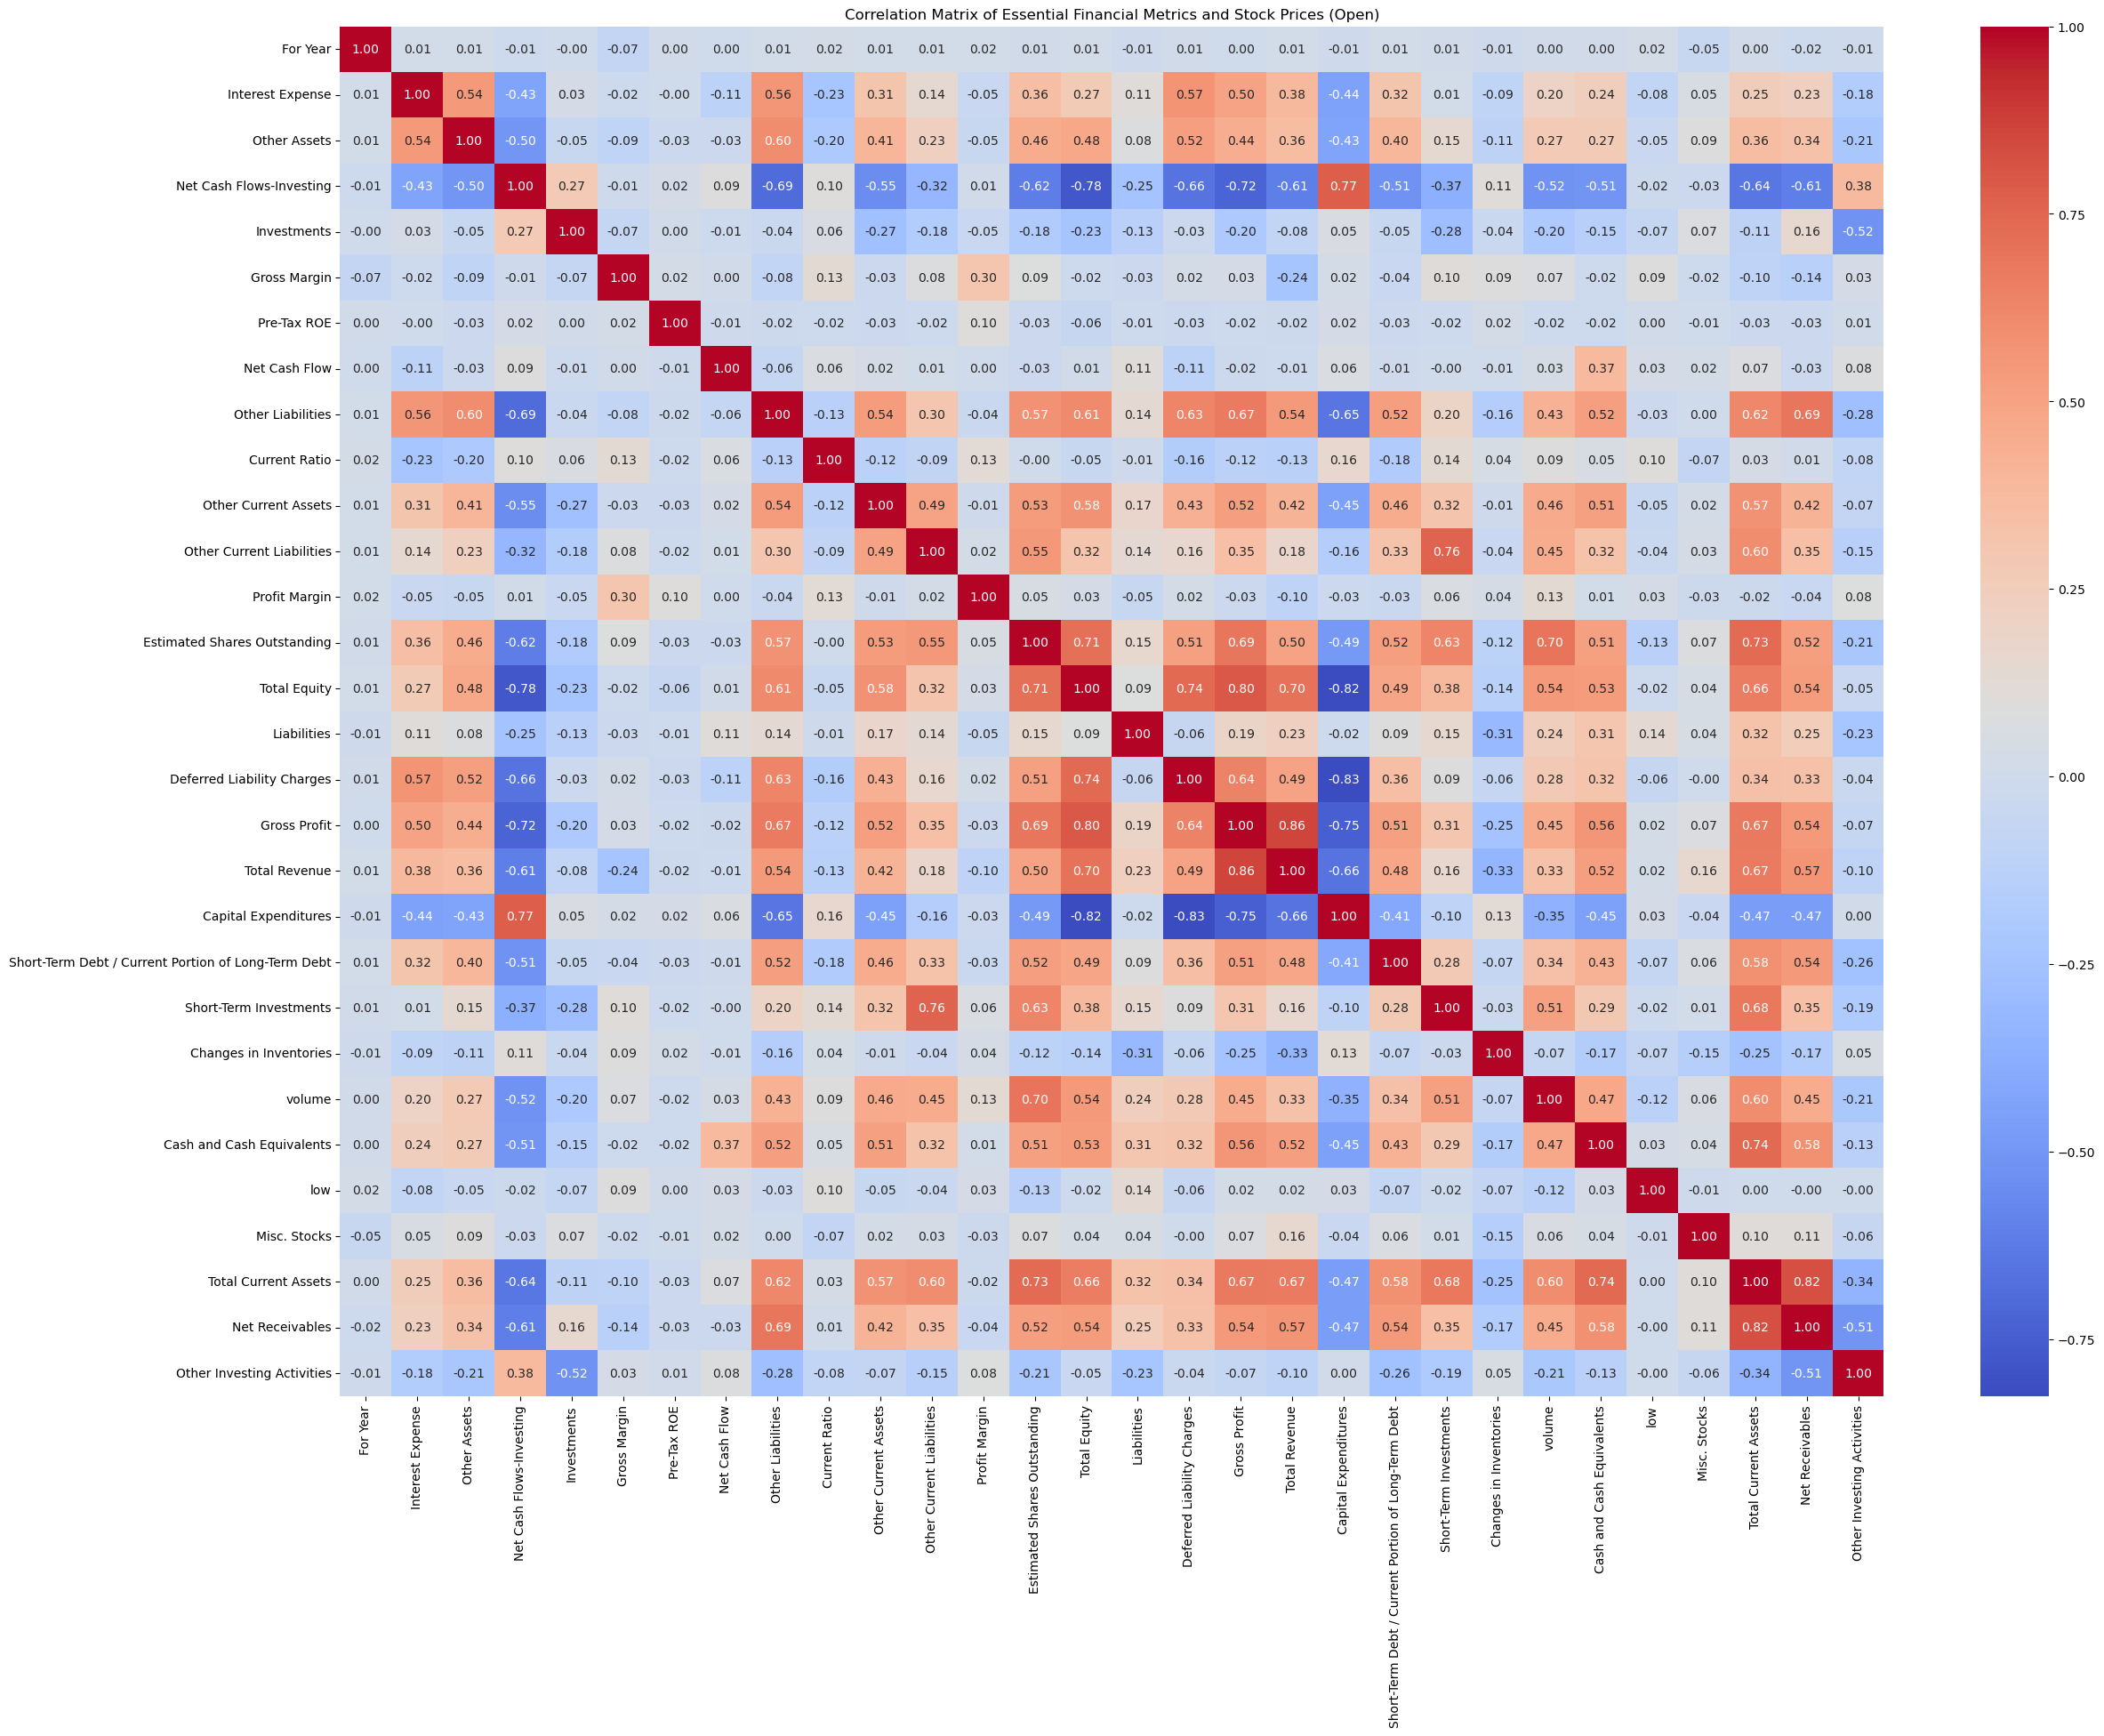

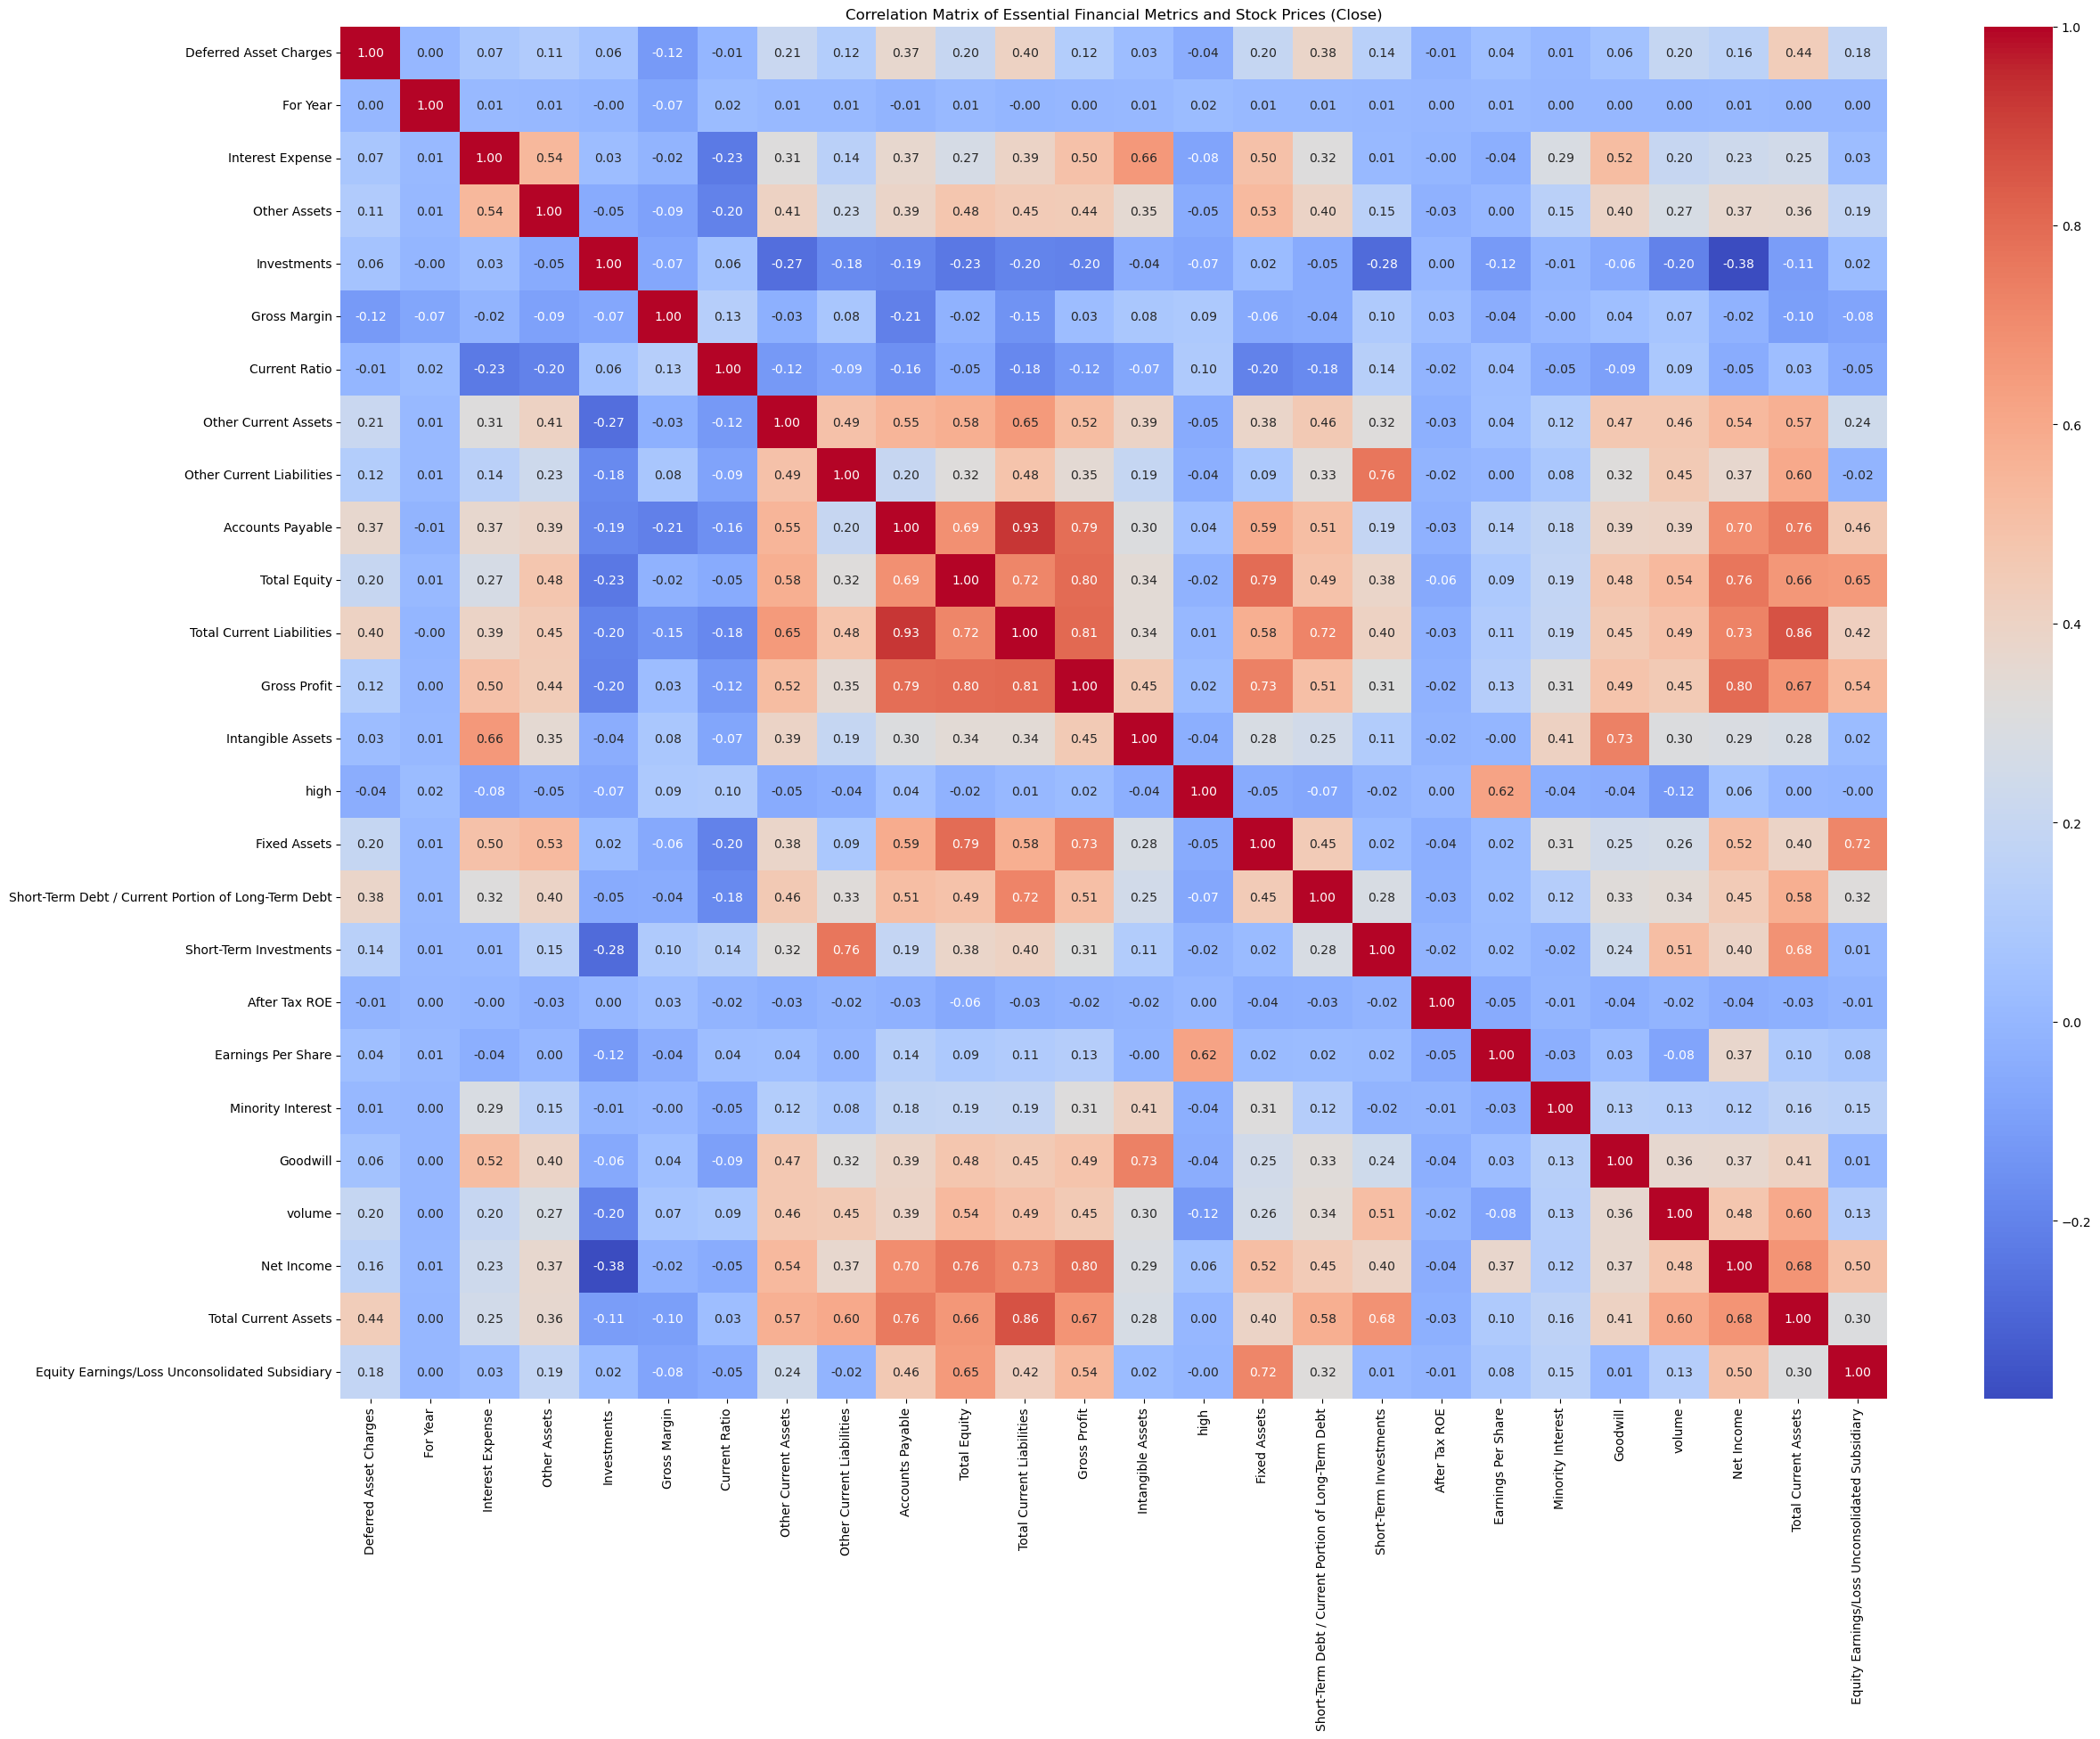

In [9]:
# Filter the aligned data for essential columns only for both open and close prices
selected_data_open = aligned_data_cleaned[list(common_features_open)]
selected_data_close = aligned_data_cleaned[list(common_features_close)]

# Remove Correlated Features For Open - Pre-tax Margin and Cost of Revenue, High
selected_data_open = selected_data_open.drop(columns=['Pre-Tax Margin', 'Cost of Revenue', 'high'])
# Remove Correlated Features For Close - Earnings Before Tax, Earnings Before Interest and Tax, Net Income Applicable to Common Shareholders, Low
selected_data_close = selected_data_close.drop(columns=['Earnings Before Interest and Tax', 'Net Income Applicable to Common Shareholders', 'low', 'Earnings Before Tax'])

# Remaining Features
print('Remaining features (open): ', len(selected_data_open.columns))
print('Remaining features (close): ', len(selected_data_close.columns))


# Calculate the correlation matrix for the selected data
correlation_matrix_open = selected_data_open.corr()
correlation_matrix_close = selected_data_close.corr()


# Visualize the correlation matrices using a heatmap
plt.figure(figsize=(28, 20))
sns.heatmap(correlation_matrix_open, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Essential Financial Metrics and Stock Prices (Open)")
plt.show()
plt.figure(figsize=(28, 20))
sns.heatmap(correlation_matrix_close, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Essential Financial Metrics and Stock Prices (Close)")
plt.show()



## Data Visuaualization
---
The following code visualizes the selected features and their relationships with the target variables (open and close prices). The visualizations include scatter plots, correlation heatmaps, and pair plots. The visualizations help to understand the relationships between the features and the target variables, and to identify any patterns or trends that may be useful for predicting stock prices.





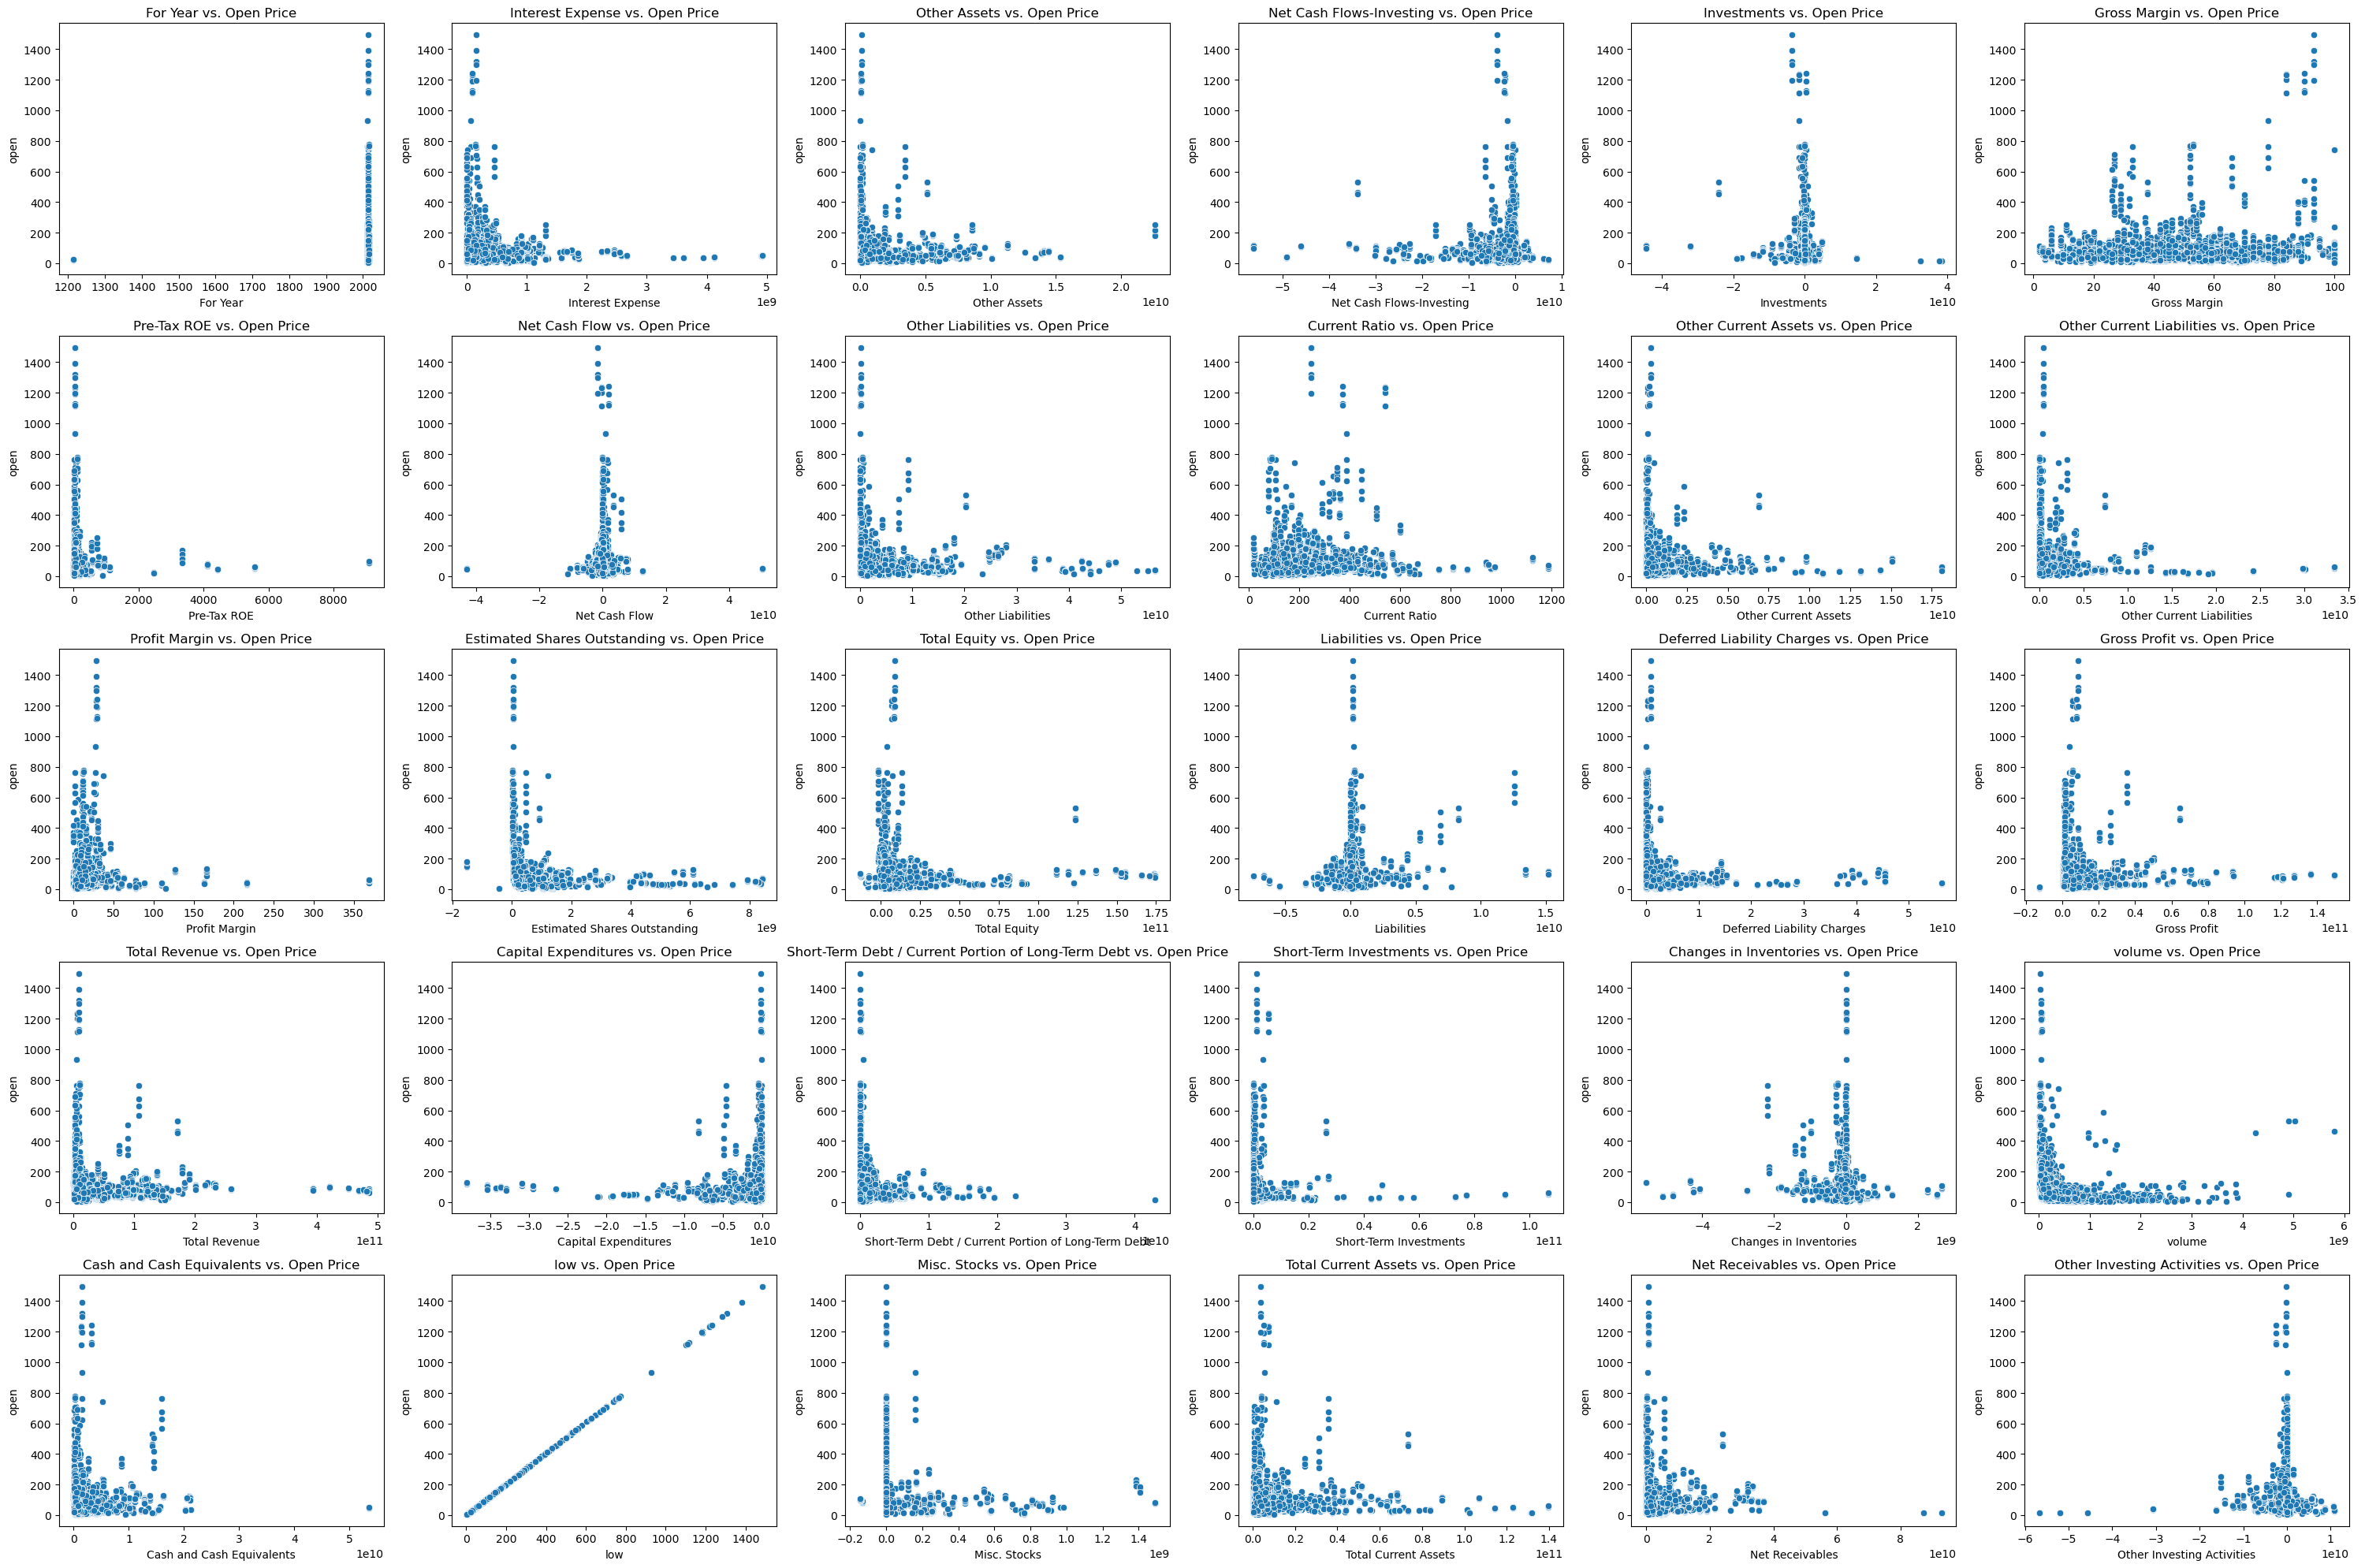

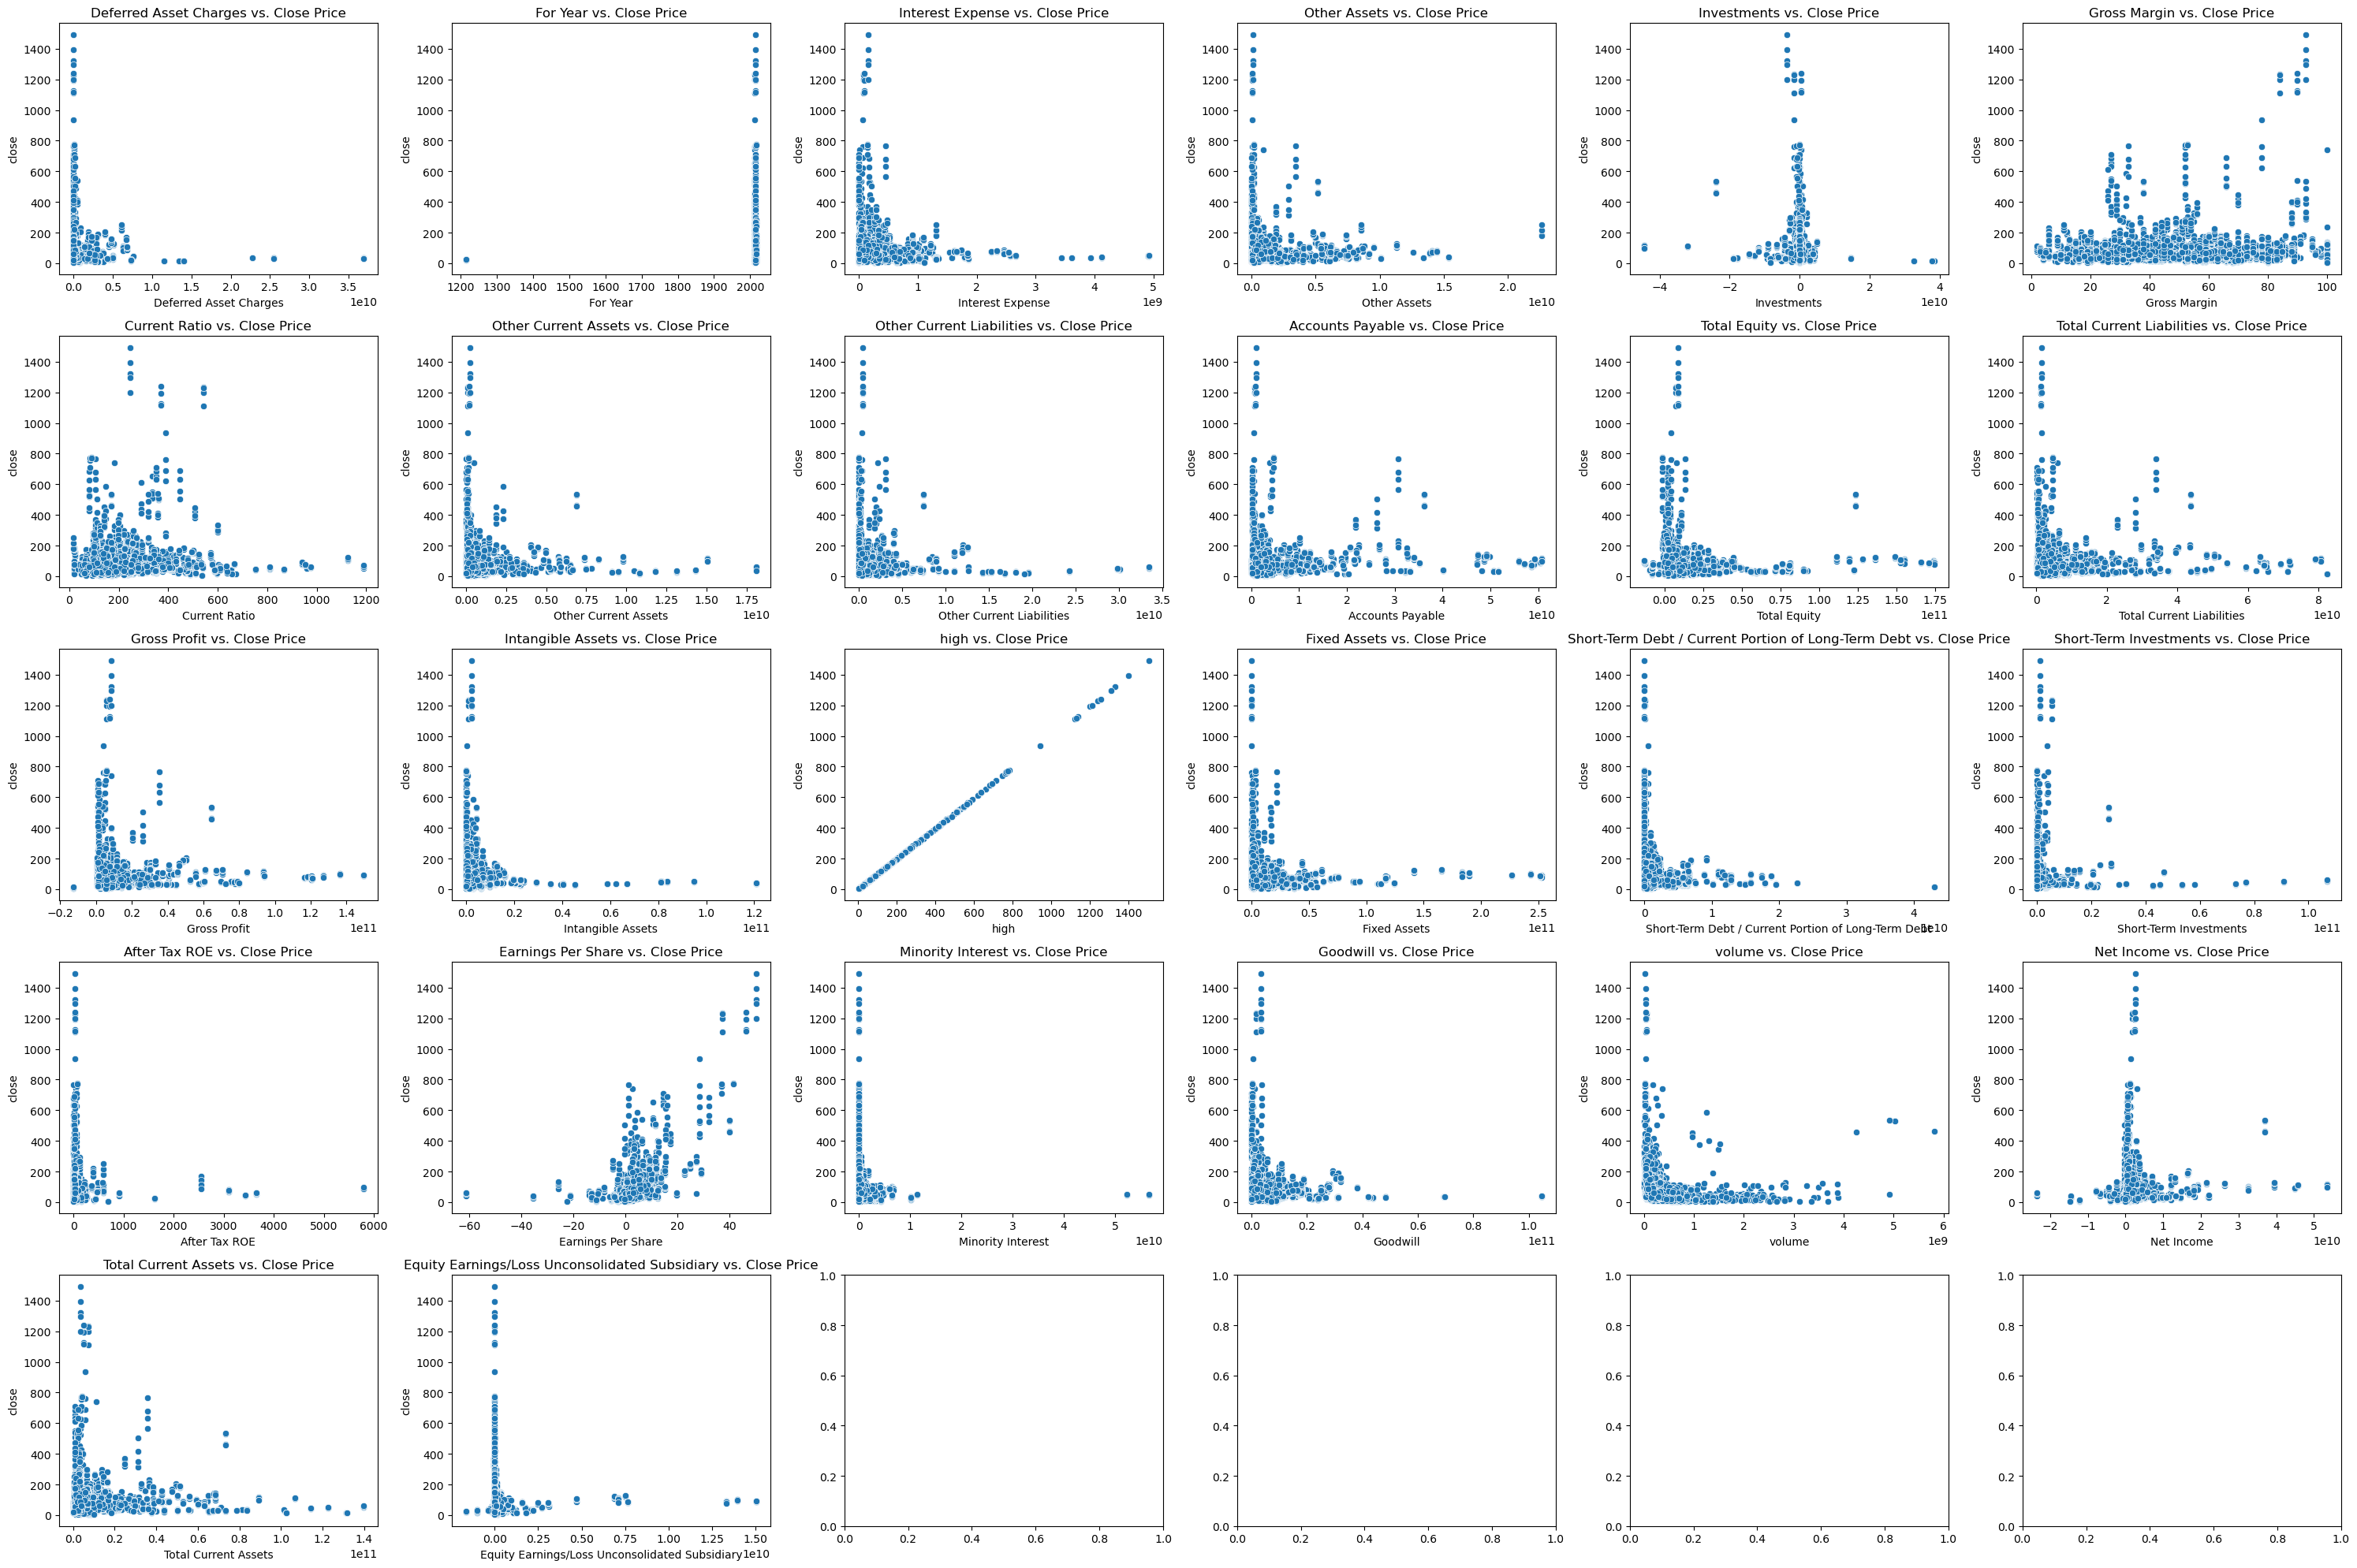

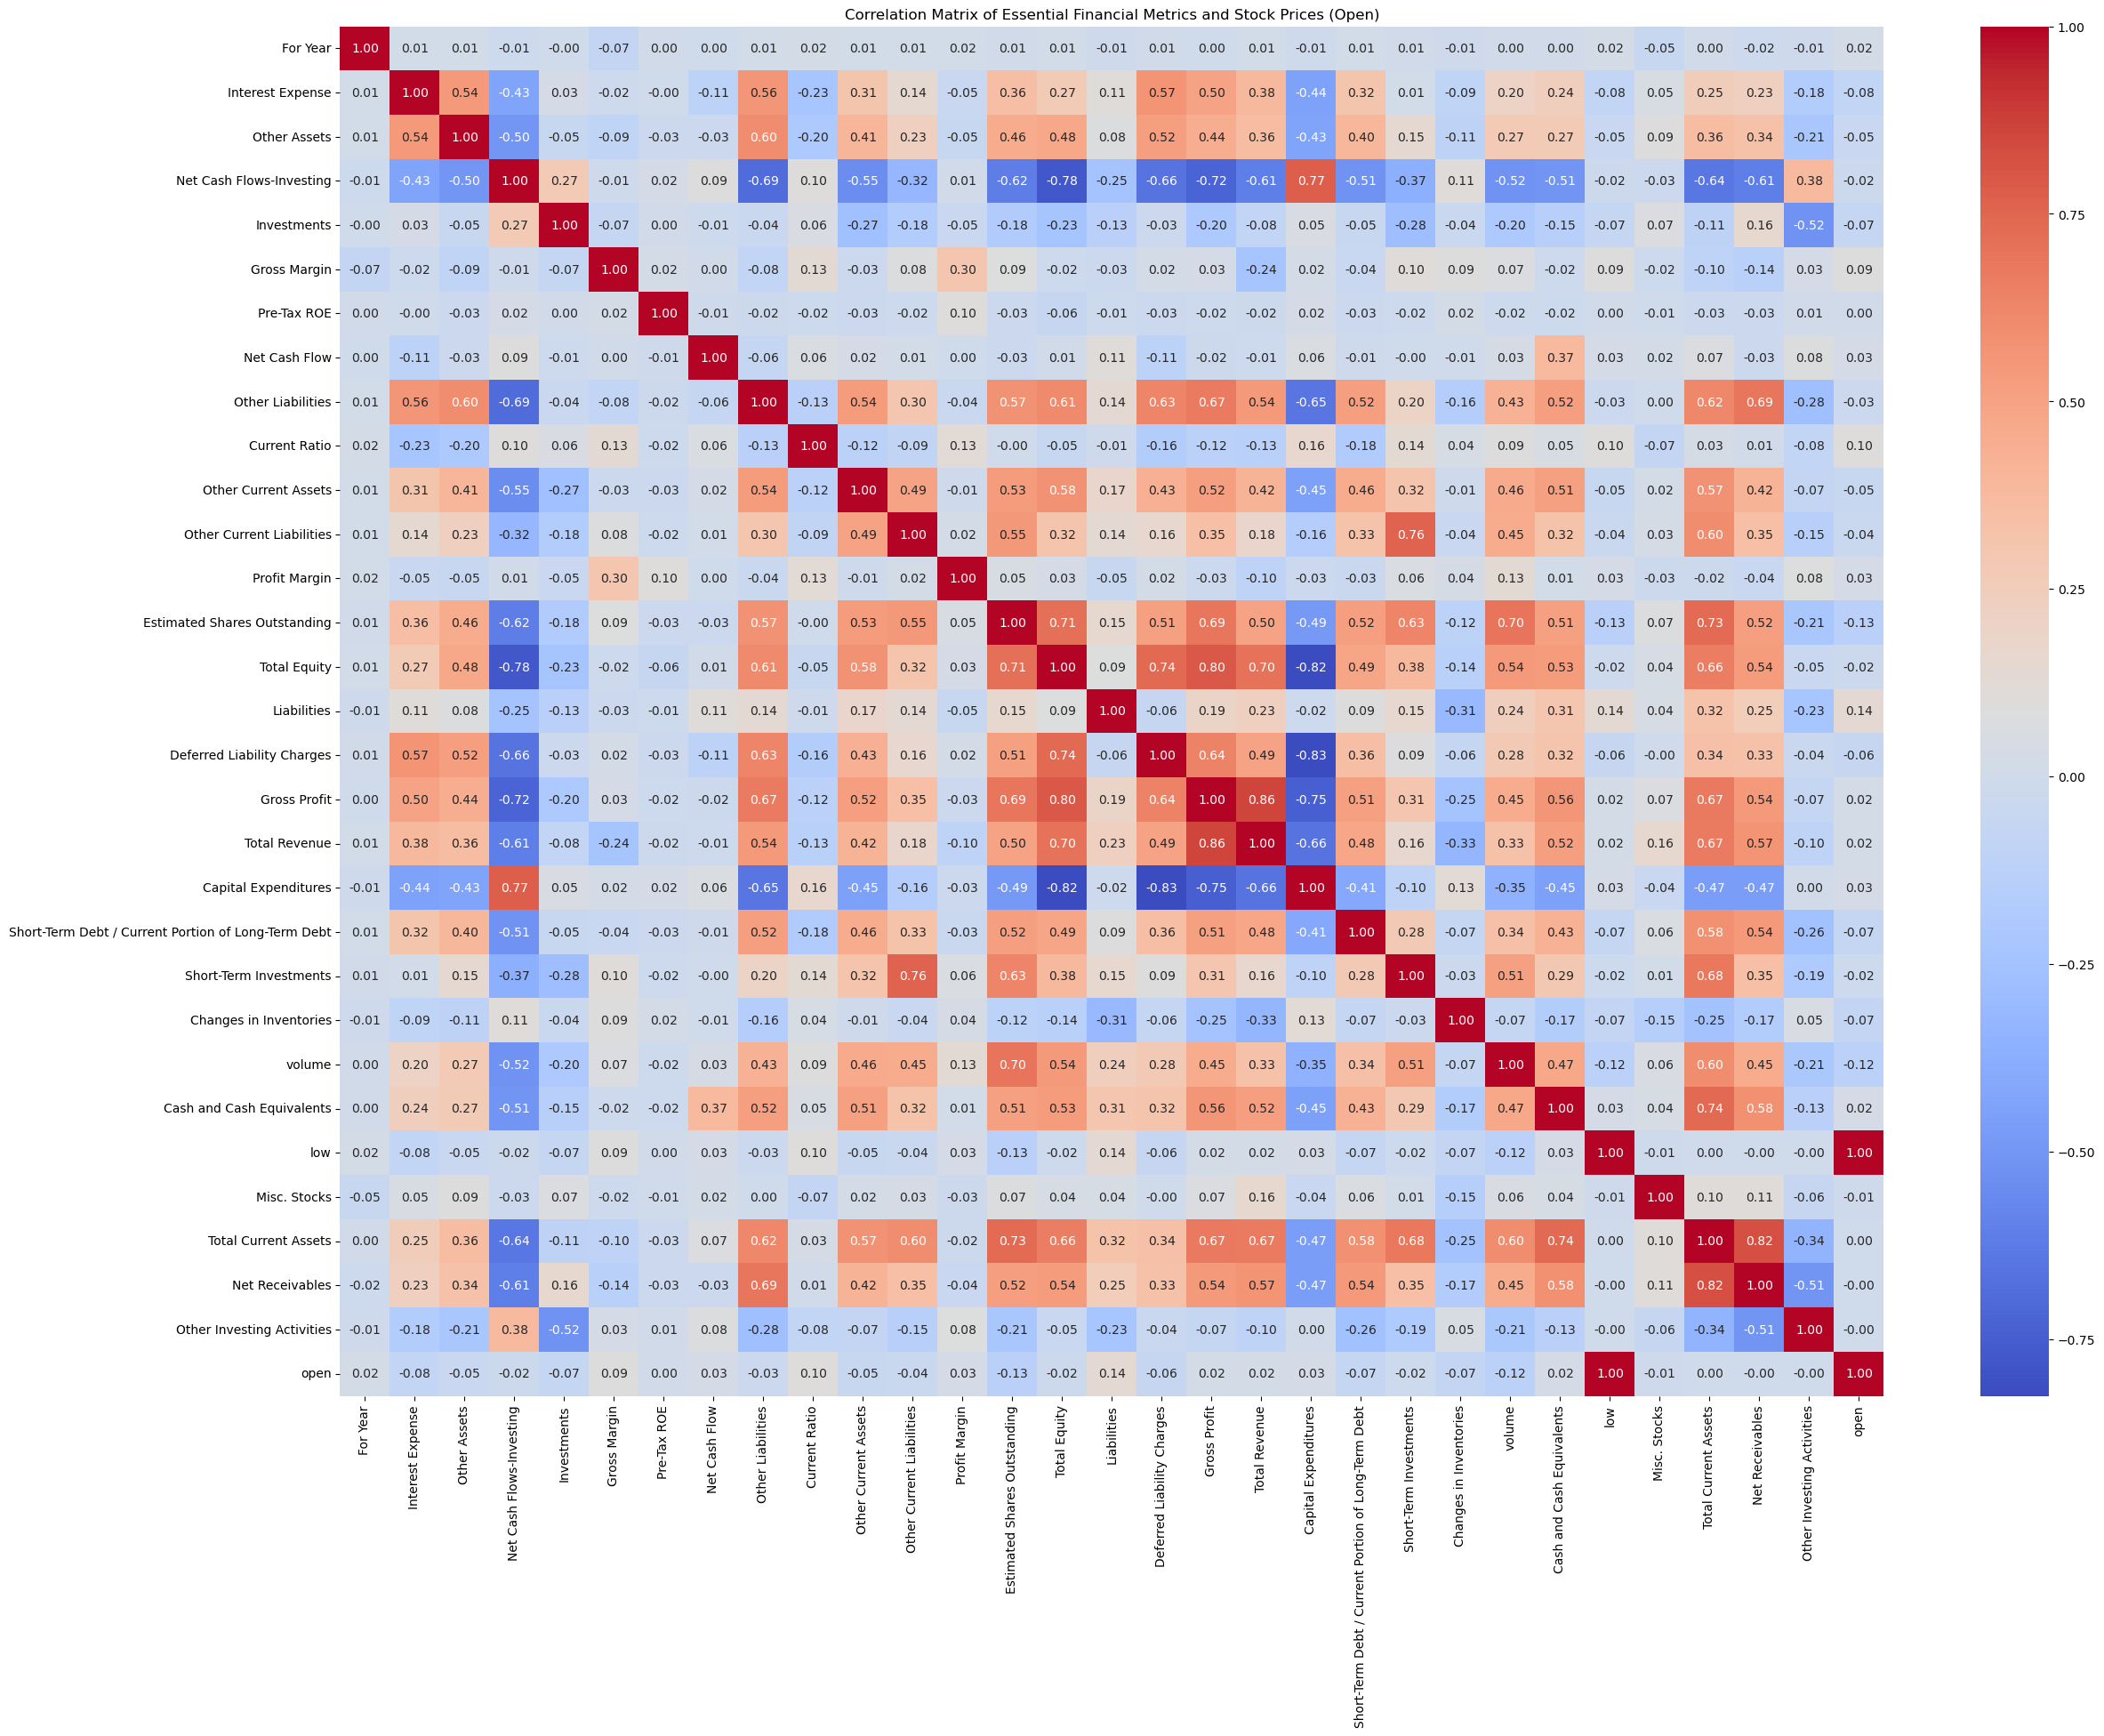

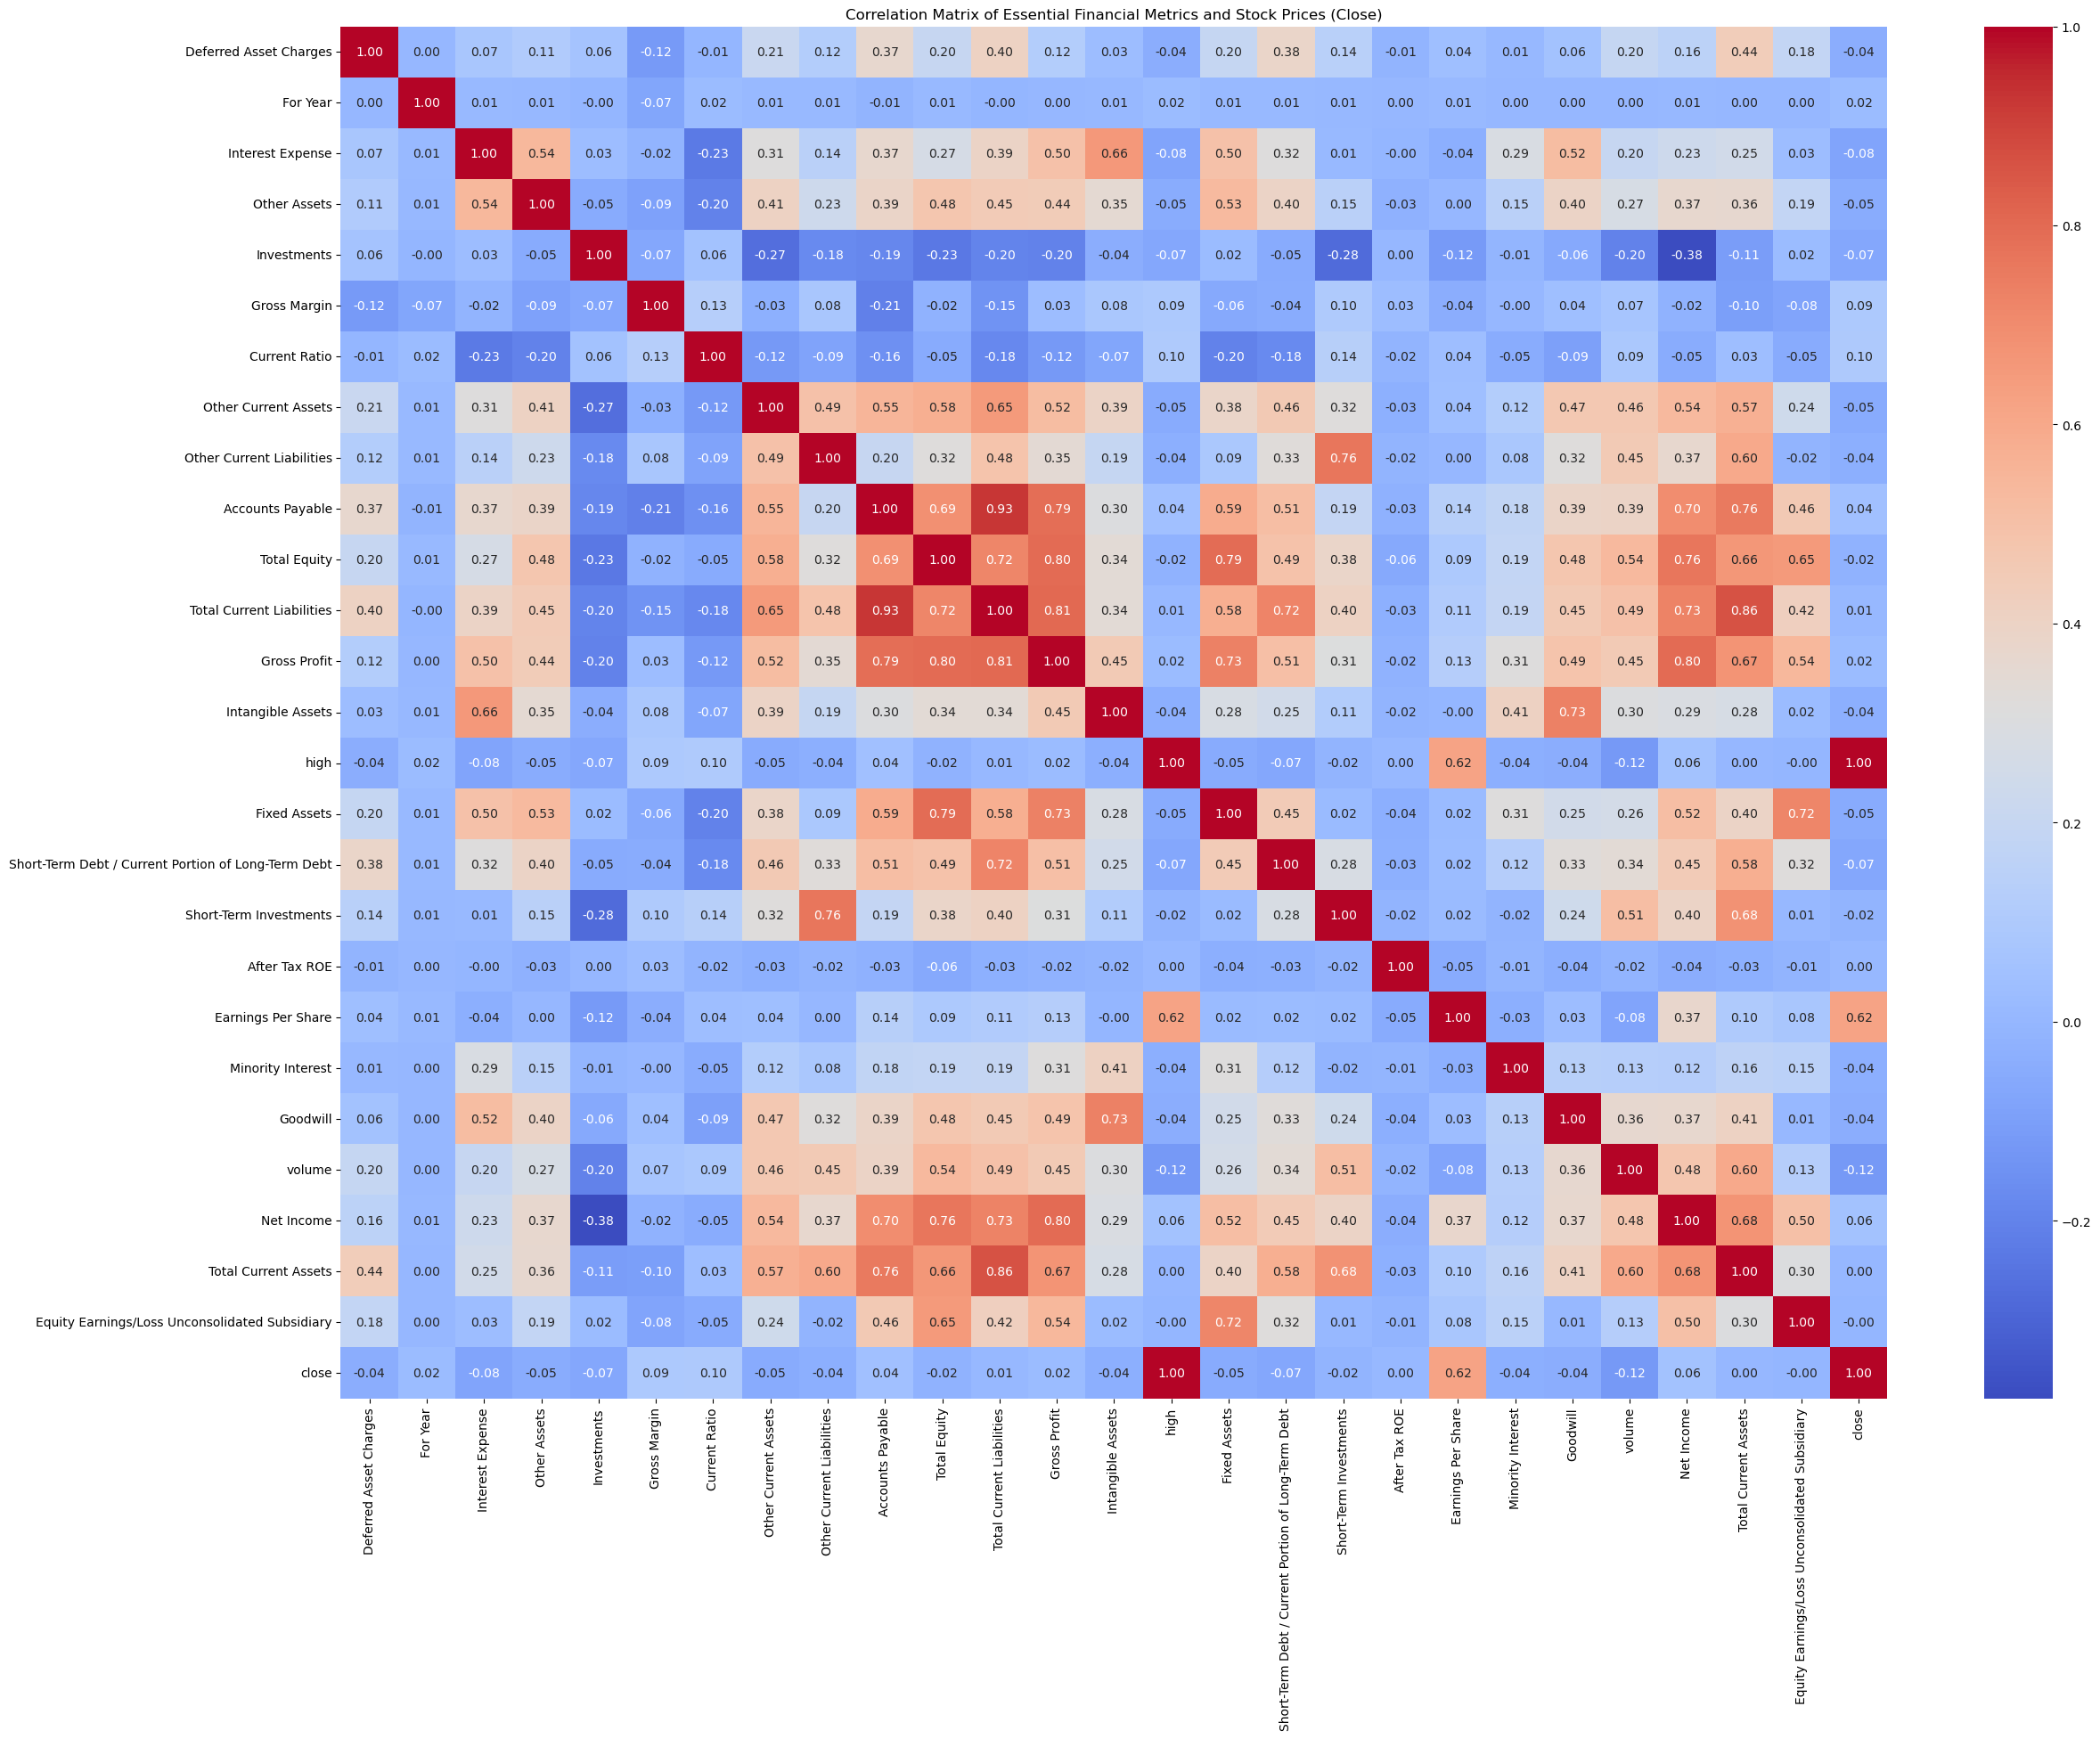

Histograms: Open


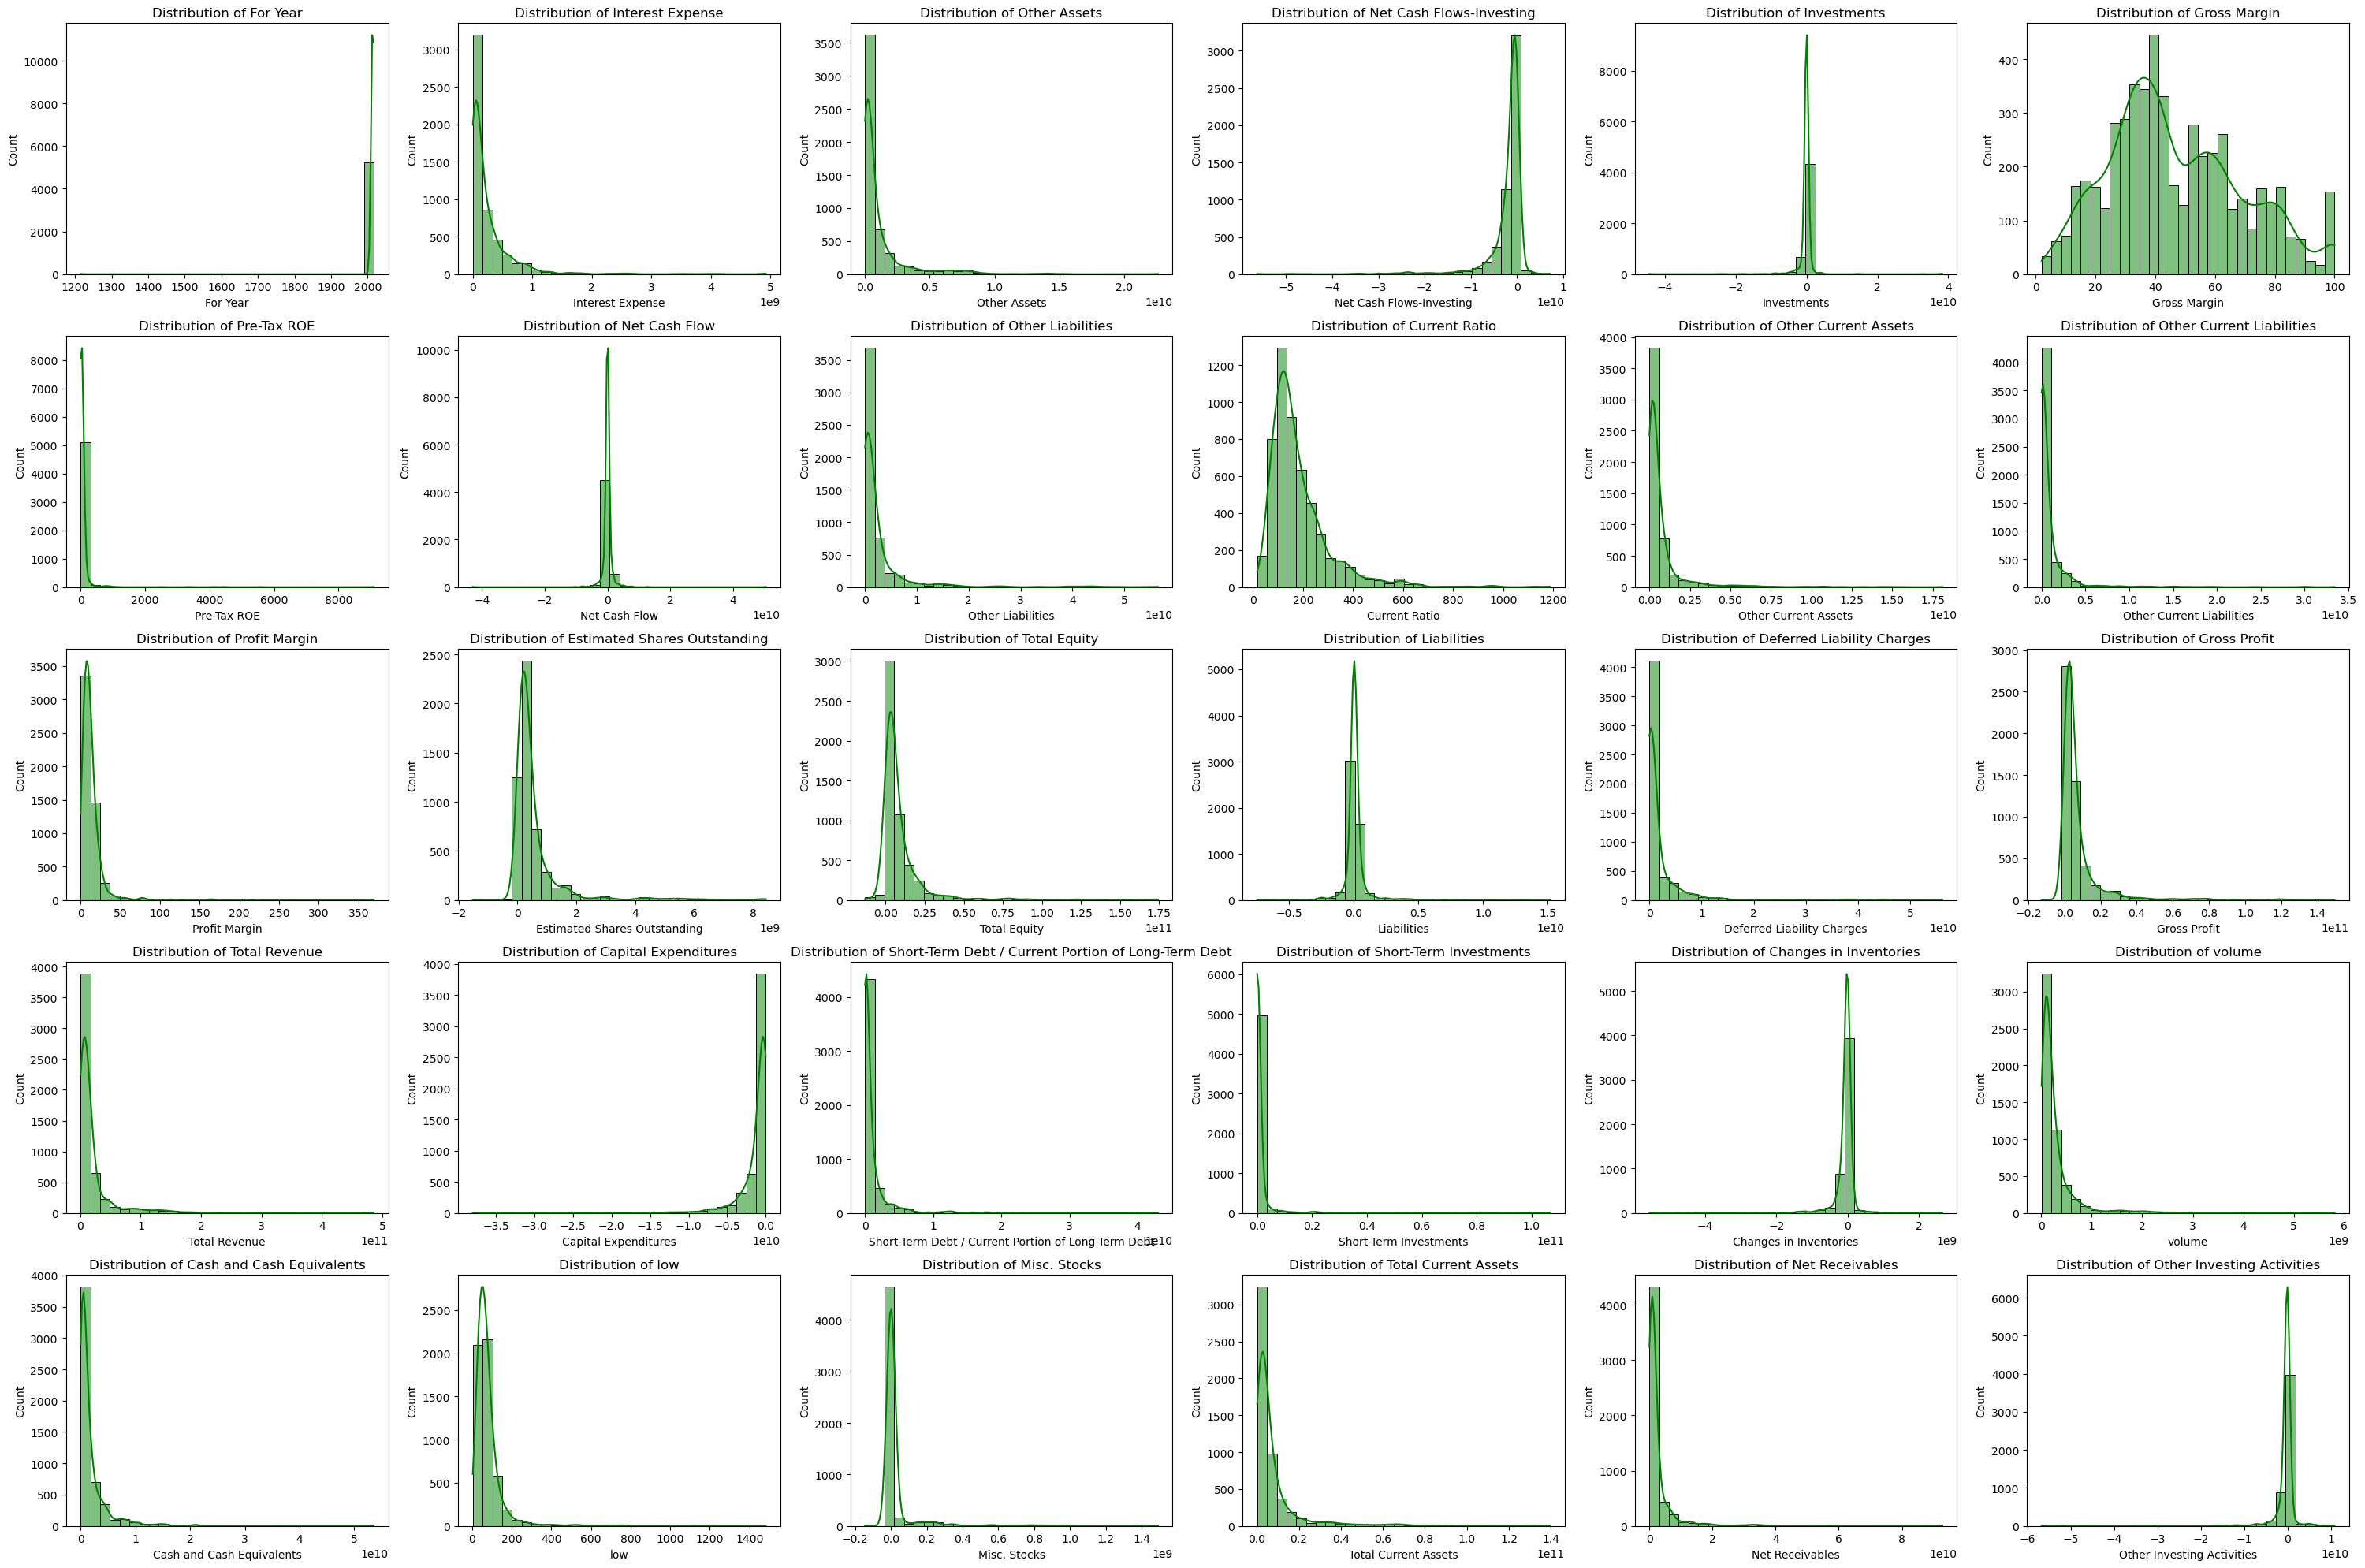

Histograms: Close


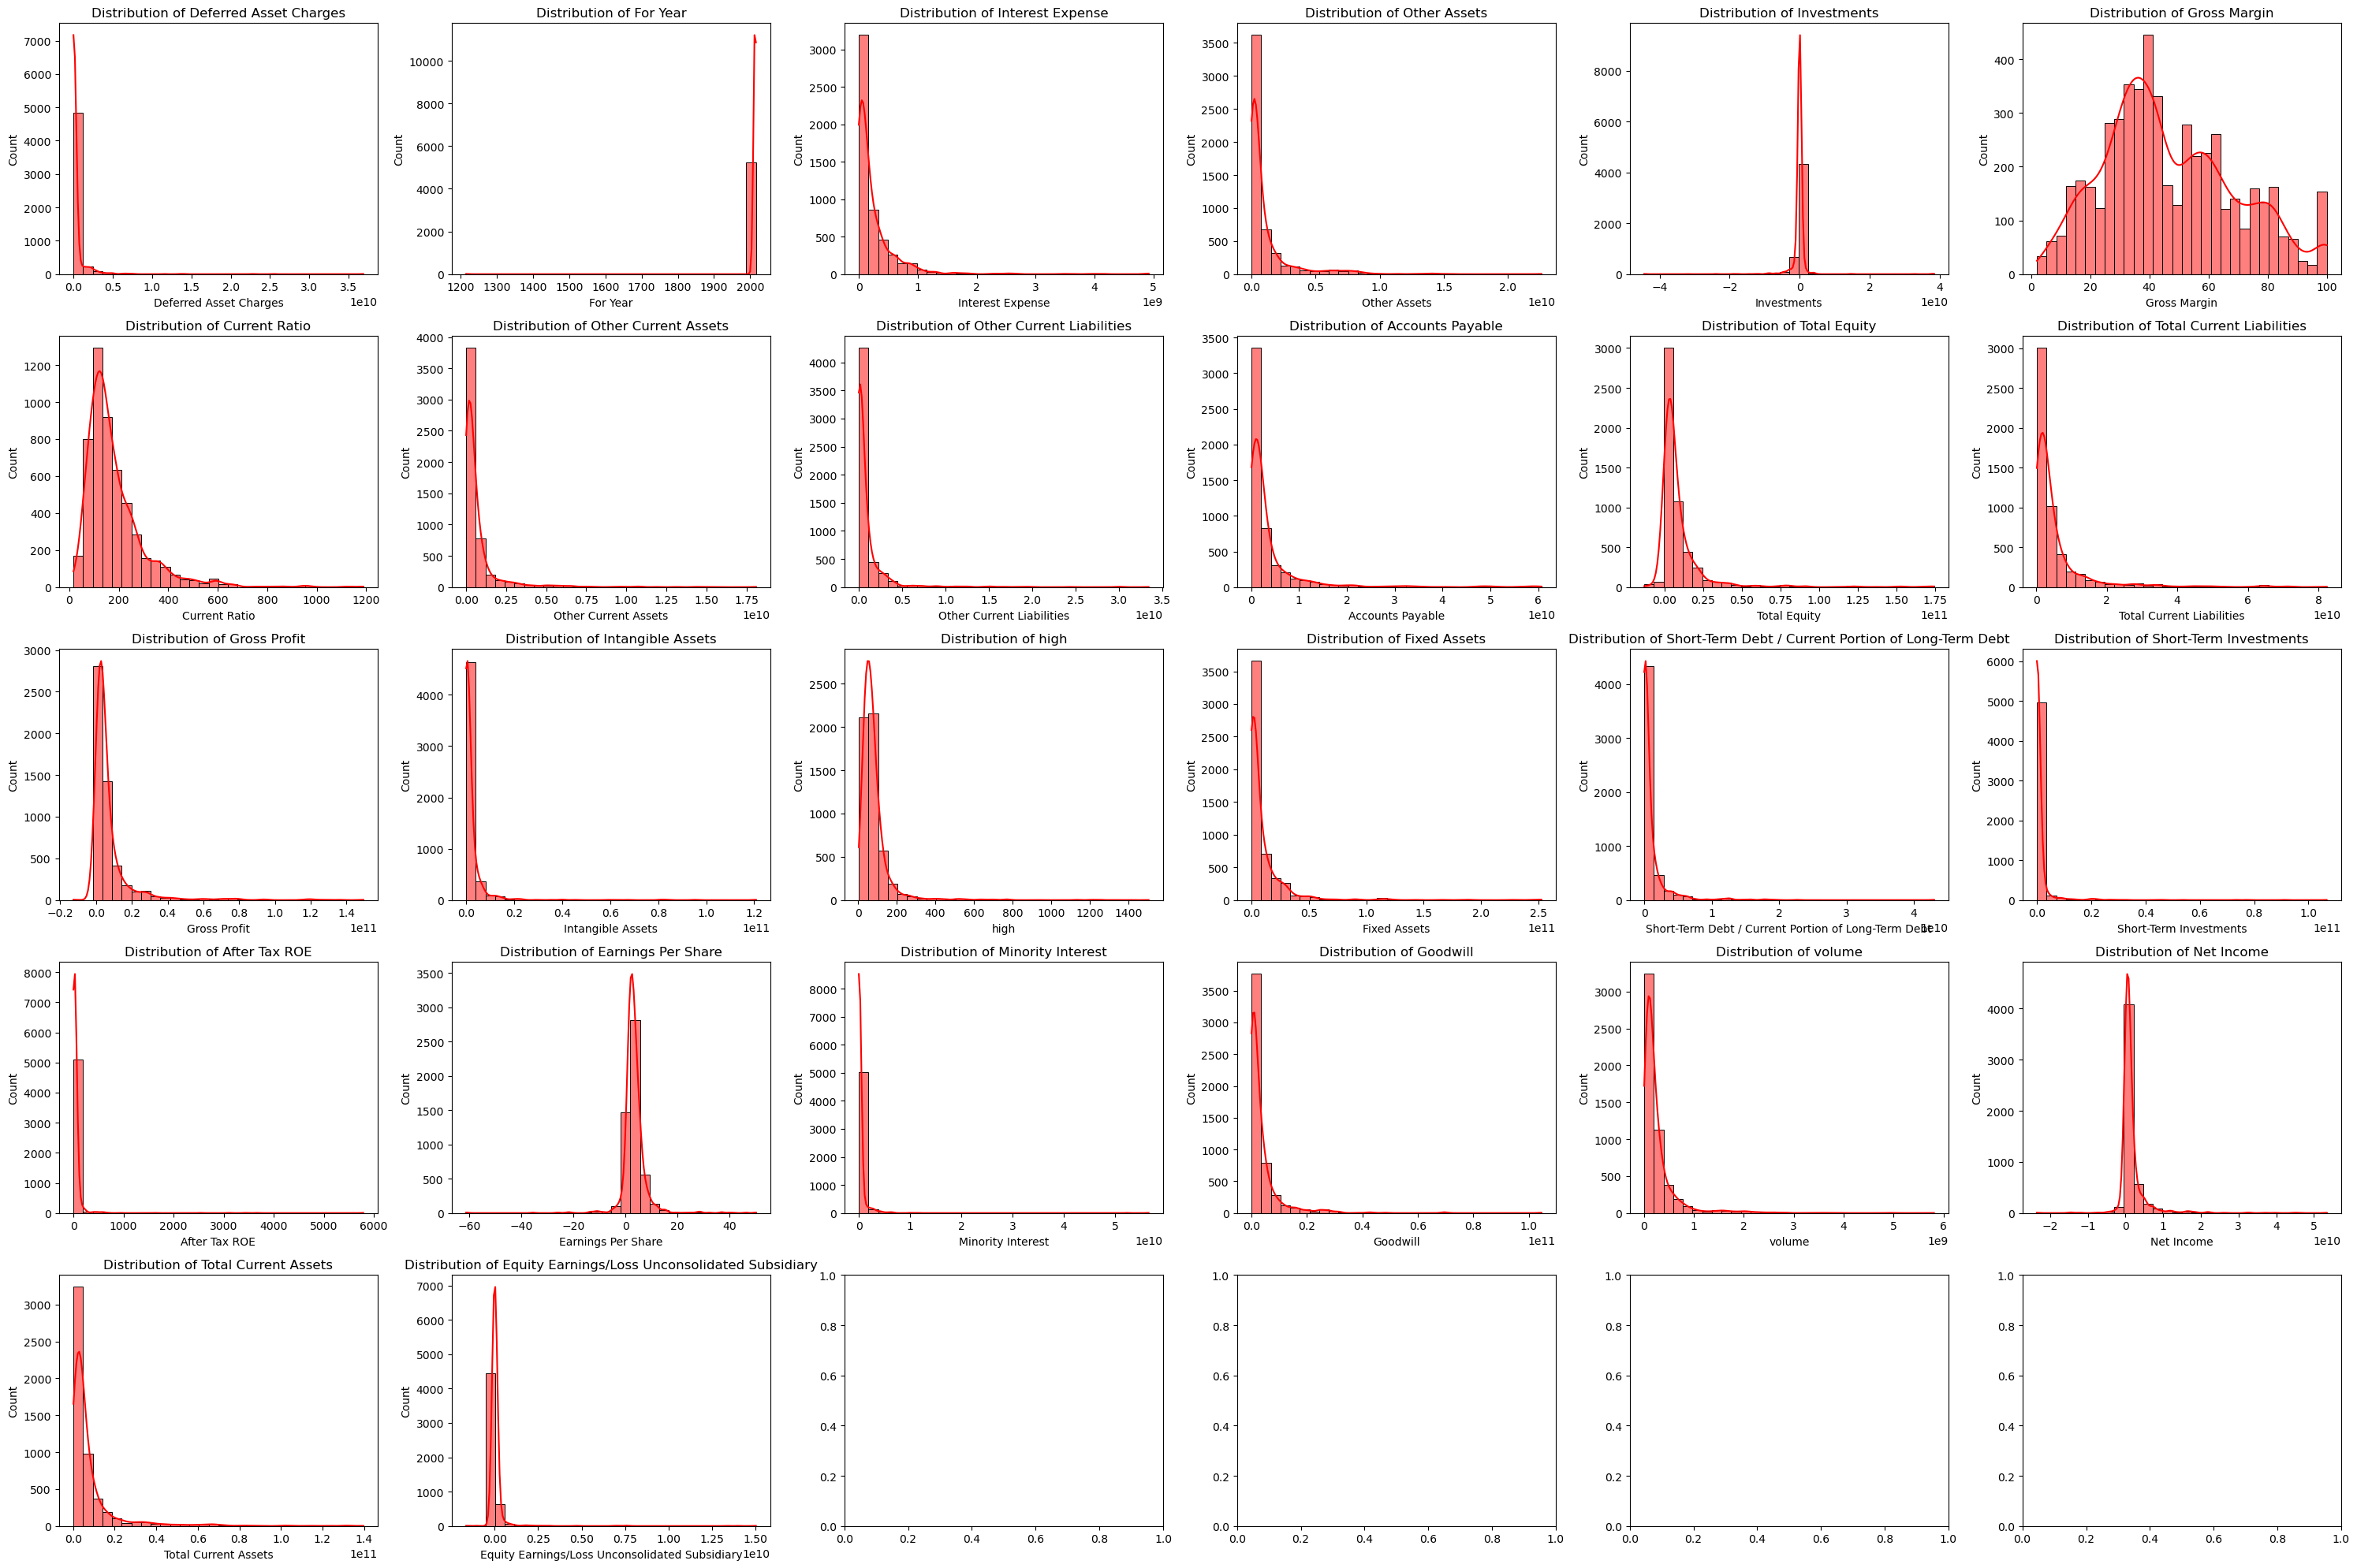

In [11]:
# Mark all open and close essential columns for analysis
# essential_columns = [
#     'open', 'close', 'high', 'low', 'Earnings Per Share', 'Liabilities', 'Cash Ratio', 'Quick Ratio', 
#     'Current Ratio', 'Gross Margin', 'Period Ending', 'date', 'Operating Income', 'Earnings Before Tax',
#     'Net Income Applicable to Common Shareholders', 'Net Income', 'Net Income-Cont. Operations', 'Income Tax', 
#     'Earnings Before Interest and Tax', 'Other Current Assets', 'Fixed Assets', 'Deferred Liability Charges',
#     'Sale and Purchase of Stock', 'Accounts Receivable', 'Long-Term Debt', 'Non-Recurring Items',
#     'Short-Term Debt / Current Portion of Long-Term Debt', 'Investments', 'Changes in Inventories',
#     'Interest Expense', 'Capital Surplus', 'volume', 'Estimated Shares Outstanding'
# ]

# # Filter the aligned data for essential columns only
# selected_data = aligned_data_cleaned[essential_columns]

# # Display a preview of the selected data
# print(selected_data.head())


# # Plot distribution of a few key financial metrics
# fig, axes = plt.subplots(2, 2, figsize=(14, 10))
# sns.histplot(aligned_data['Earnings Per Share'], bins=30, kde=True, ax=axes[0, 0])
# axes[0, 0].set_title("Distribution of Earnings Per Share")

# sns.histplot(aligned_data['Total Liabilities'], bins=30, kde=True, ax=axes[0, 1])
# axes[0, 1].set_title("Distribution of Total Liabilities")

# sns.histplot(aligned_data['Capital Surplus'], bins=30, kde=True, ax=axes[1, 0])
# axes[1, 0].set_title("Distribution of Capital Surplus")

# sns.histplot(aligned_data['Estimated Shares Outstanding'], bins=30, kde=True, ax=axes[1, 1])
# axes[1, 1].set_title("Distribution of Estimated Shares Outstanding")

# plt.tight_layout()
# plt.show()

# selected_data = aligned_data_cleaned[['symbol'] + essential_columns]
# print(selected_data.head())
# print('shape:', selected_data.shape)

# =============================================================================

# Get Selected Data for Open and Close Prices
final_data_open = aligned_data_cleaned[['symbol'] + list(selected_data_open.columns) + ['open']]
final_data_close = aligned_data_cleaned[['symbol'] + list(selected_data_close.columns) + ['close']]

# SCATTER PLOTS ----------------------------------------------

# Plot scatter plots of selected features against open and close prices
# Open - 30 features
# Close - 26 features
fig, axes = plt.subplots(5, 6, figsize=(30, 20))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i, feature in enumerate(selected_data_open.columns):
    sns.scatterplot(x=feature, y='open', data=final_data_open, ax=axes[i // 6, i % 6])
    axes[i // 6, i % 6].set_title(f"{feature} vs. Open Price")
    
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(5, 6, figsize=(30, 20))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i, feature in enumerate(selected_data_close.columns):
    sns.scatterplot(x=feature, y='close', data=final_data_close, ax=axes[i // 6, i % 6])
    axes[i // 6, i % 6].set_title(f"{feature} vs. Close Price")
    
plt.tight_layout()
plt.show()
    
    
# Correlation Heatmaps ----------------------------------------------
# Open
correlation_matrix_open = final_data_open.drop(columns=['symbol']).corr()
plt.figure(figsize=(28, 20))
sns.heatmap(correlation_matrix_open, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Essential Financial Metrics and Stock Prices (Open)")
plt.show()

# Close
correlation_matrix_close = final_data_close.drop(columns=['symbol']).corr()
plt.figure(figsize=(28, 20))
sns.heatmap(correlation_matrix_close, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Essential Financial Metrics and Stock Prices (Close)")
plt.show()


# Histograms ----------------------------------------------

# Plot histograms of selected features
# Open - 30 features
fig, axes = plt.subplots(5, 6, figsize=(30, 20))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

print("Histograms: Open")
for i, feature in enumerate(selected_data_open.columns):
    sns.histplot(final_data_open[feature], bins=30, kde=True, ax=axes[i // 6, i % 6], color='green')
    axes[i // 6, i % 6].set_title(f"Distribution of {feature}")
    
plt.tight_layout()
plt.show()

# Close - 26 features
print("Histograms: Close")
fig, axes = plt.subplots(5, 6, figsize=(30, 20))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i, feature in enumerate(selected_data_close.columns):
    sns.histplot(final_data_close[feature], bins=30, kde=True, ax=axes[i // 6, i % 6], color='red')
    axes[i // 6, i % 6].set_title(f"Distribution of {feature}")
    
plt.tight_layout()
plt.show()



In [12]:
# securities_df = pd.read_csv('data/securities.csv')
# securities_selected = securities_df[['Ticker symbol', 'GICS Sector', 'GICS Sub Industry']]

# final_df = selected_data.merge(securities_selected, left_on='symbol', right_on='Ticker symbol', how='left')

# final_df.drop(columns=['Ticker symbol'], inplace=True)
# print(final_df.head())
# final_df.shape

final_df_open = final_data_open.drop(columns=['symbol'])
final_df_close = final_data_close.drop(columns=['symbol'])
final_df_with_symbols_open = final_data_open
final_df_with_symbols_close = final_data_close
print('Final Dataframe Shape With Symbol (Open): ', final_df_with_symbols_open.shape)
print('Final Dataframe Shape With Symbol (Close): ', final_df_with_symbols_close.shape)
print('Final Dataframe Shape (Open): ', final_df_open.shape)
print('Final Dataframe Shape (Close): ', final_df_close.shape)
print('Open Features: ',final_df_open.columns)
print('Close Features: ', final_df_close.columns)


Final Dataframe Shape With Symbol (Open):  (5243, 32)
Final Dataframe Shape With Symbol (Close):  (5243, 28)
Final Dataframe Shape (Open):  (5243, 31)
Final Dataframe Shape (Close):  (5243, 27)
Open Features:  Index(['For Year', 'Interest Expense', 'Other Assets',
       'Net Cash Flows-Investing', 'Investments', 'Gross Margin',
       'Pre-Tax ROE', 'Net Cash Flow', 'Other Liabilities', 'Current Ratio',
       'Other Current Assets', 'Other Current Liabilities', 'Profit Margin',
       'Estimated Shares Outstanding', 'Total Equity', 'Liabilities',
       'Deferred Liability Charges', 'Gross Profit', 'Total Revenue',
       'Capital Expenditures',
       'Short-Term Debt / Current Portion of Long-Term Debt',
       'Short-Term Investments', 'Changes in Inventories', 'volume',
       'Cash and Cash Equivalents', 'low', 'Misc. Stocks',
       'Total Current Assets', 'Net Receivables', 'Other Investing Activities',
       'open'],
      dtype='object')
Close Features:  Index(['Deferred As

In [13]:
######IMPLEMENTATION######

# import necessary libs
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (mean_squared_error, r2_score, mean_absolute_error)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, StackingRegressor

# helper funcs
def predict(X, theta, degree):
    X_poly = add_polynomial_features(X, degree)
    return X_poly.dot(theta)

def add_polynomial_features(X, degree):
    X_poly = np.ones((X.shape[0], 1))  # Start with a column of ones (for the intercept)
    for d in range(1, degree + 1):
        X_poly = np.hstack((X_poly, X ** d))  # Add each polynomial degree column
    return X_poly

def polynomial_regression(X, y, degree, learning_rate, n_iterations, alpha, max_gradient=1e4):
    X_poly = add_polynomial_features(X, degree)
    y = y.reshape(-1, 1)
    m, n = X_poly.shape

    # Initialize theta (parameter vector) with zeros
    theta = np.zeros((n, 1))

    # Gradient descent
    for i in range(n_iterations):
        predictions = X_poly.dot(theta)
        errors = predictions - y
        gradients = (2 / m) * X_poly.T.dot(errors) + (2 * alpha * theta)

        # Clip gradients to prevent excessively large updates
        gradients = np.clip(gradients, -max_gradient, max_gradient)

        # Update theta
        theta -= learning_rate * gradients

    return theta
    

In [14]:
def compute_additional_metrics(y_test, y_pred):
    # y_test and y_pred to numpy arrays
    y_test = np.array(y_test).flatten()
    y_pred = np.array(y_pred).flatten()

    # Mean Absolute Error
    mae = mean_absolute_error(y_test, y_pred)

    # Mean Absolute Percentage Error
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    # directional accuracy
    actual_direction = np.sign(y_test[1:] - y_test[:-1])
    predicted_direction = np.sign(y_pred[1:] - y_pred[:-1])
    directional_accuracy = np.mean(actual_direction == predicted_direction) * 100

    # correlation coefficient
    correlation = np.corrcoef(y_test, y_pred)[0, 1]

    # Sharpe Ratio
    # calculate predicted returns
    predicted_returns = y_pred[1:] - y_pred[:-1]

    if np.std(predicted_returns) != 0:
        sharpe_ratio = (np.mean(predicted_returns) / np.std(predicted_returns)) * np.sqrt(252)
    else:
        sharpe_ratio = 0

    return mae, mape, directional_accuracy, correlation, sharpe_ratio

In [15]:
# Func to run all models and output results
def train_and_evaluate_model(X, y, dataset_name):
    # split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # apply StandardScaler to X
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    results = {}

    # SKLEARN LINEAR REGRESSION ----------------------------------------------

    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # eval
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # compute metrics
    mae, mape, directional_accuracy, correlation, sharpe_ratio = compute_additional_metrics(y_test, y_pred)

    results['Linear Regression'] = {
        'MSE': mse,
        'R2': r2,
        'MAE': mae,
        'MAPE': mape,
        'Directional Accuracy': directional_accuracy,
        'Correlation Coefficient': correlation,
        'Sharpe Ratio': sharpe_ratio
    }

    print(f"{dataset_name} - Linear Regression")
    print("Mean Squared Error:", mse)
    print("R-squared Score:", r2)
    print()

    # SKLEARN POLYNOMIAL REGRESSION DEGREE 1 ----------------------------------------------

    poly1 = PolynomialFeatures(degree=1)
    X_train_poly1 = poly1.fit_transform(X_train_scaled)
    X_test_poly1 = poly1.transform(X_test_scaled)

    model = LinearRegression()
    model.fit(X_train_poly1, y_train)
    y_pred = model.predict(X_test_poly1)

    # eval
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # compute metrics
    mae, mape, directional_accuracy, correlation, sharpe_ratio = compute_additional_metrics(y_test, y_pred)

    results['Polynomial Regression Degree 1'] = {
        'MSE': mse,
        'R2': r2,
        'MAE': mae,
        'MAPE': mape,
        'Directional Accuracy': directional_accuracy,
        'Correlation Coefficient': correlation,
        'Sharpe Ratio': sharpe_ratio
    }

    print(f"{dataset_name} - Polynomial Regression Degree 1")
    print("Mean Squared Error:", mse)
    print("R-squared Score:", r2)
    print()

    # SKLEARN POLYNOMIAL REGRESSION DEGREE 2 ----------------------------------------------

    poly2 = PolynomialFeatures(degree=2)
    X_train_poly2 = poly2.fit_transform(X_train_scaled)
    X_test_poly2 = poly2.transform(X_test_scaled)

    model = LinearRegression()
    model.fit(X_train_poly2, y_train)
    y_pred = model.predict(X_test_poly2)

    # eval
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # compute metrics
    mae, mape, directional_accuracy, correlation, sharpe_ratio = compute_additional_metrics(y_test, y_pred)

    results['Polynomial Regression Degree 2'] = {
        'MSE': mse,
        'R2': r2,
        'MAE': mae,
        'MAPE': mape,
        'Directional Accuracy': directional_accuracy,
        'Correlation Coefficient': correlation,
        'Sharpe Ratio': sharpe_ratio
    }

    print(f"{dataset_name} - Polynomial Regression Degree 2")
    print("Mean Squared Error:", mse)
    print("R-squared Score:", r2)
    print()

    # CUSTOM POLYNOMIAL REGRESSION ----------------------------------------------

    # test polynomial degrees 1-3
    for degree in range(1, 4):
        theta = polynomial_regression(
            X_train_scaled, y_train.values, degree=degree,
            learning_rate=0.001, n_iterations=10000, alpha=0.01
        )

        # Ensure theta is valid
        if not np.isnan(theta).any():
            # predict on the test set
            y_pred = predict(X_test_scaled, theta, degree)

            # eval
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            # compute metrics
            mae, mape, directional_accuracy, correlation, sharpe_ratio = compute_additional_metrics(y_test, y_pred)

            model_name = f'Custom Polynomial Regression Degree {degree}'
            results[model_name] = {
                'MSE': mse,
                'R2': r2,
                'MAE': mae,
                'MAPE': mape,
                'Directional Accuracy': directional_accuracy,
                'Correlation Coefficient': correlation,
                'Sharpe Ratio': sharpe_ratio
            }

            print(f"{dataset_name} - Custom Polynomial Regression Degree {degree}")
            print("Mean Squared Error:", mse)
            print("R-squared Score:", r2)
            print()

    # K-NEAREST NEIGHBORS REGRESSION ----------------------------------------------

    knn_neighbors = [3, 5, 7]
    for k in knn_neighbors:
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(X_train_scaled, y_train)
        y_pred = knn.predict(X_test_scaled)

        # eval
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # compute metrics
        mae, mape, directional_accuracy, correlation, sharpe_ratio = compute_additional_metrics(y_test, y_pred)

        model_name = f'KNN Regression (k={k})'
        results[model_name] = {
            'MSE': mse,
            'R2': r2,
            'MAE': mae,
            'MAPE': mape,
            'Directional Accuracy': directional_accuracy,
            'Correlation Coefficient': correlation,
            'Sharpe Ratio': sharpe_ratio
        }

        print(f"{dataset_name} - KNN Regression (k={k})")
        print("Mean Squared Error:", mse)
        print("R-squared Score:", r2)
        print()

    # DECISION TREE REGRESSION ----------------------------------------------

    max_depths = [3, 5, 7, None]
    for depth in max_depths:
        dt = DecisionTreeRegressor(max_depth=depth, random_state=42)
        dt.fit(X_train_scaled, y_train)
        y_pred = dt.predict(X_test_scaled)

        # eval
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # compute metrics
        mae, mape, directional_accuracy, correlation, sharpe_ratio = compute_additional_metrics(y_test, y_pred)

        depth_label = f'Decision Tree Regression (max_depth={depth})'
        results[depth_label] = {
            'MSE': mse,
            'R2': r2,
            'MAE': mae,
            'MAPE': mape,
            'Directional Accuracy': directional_accuracy,
            'Correlation Coefficient': correlation,
            'Sharpe Ratio': sharpe_ratio
        }

        print(f"{dataset_name} - Decision Tree Regression (max_depth={depth})")
        print("Mean Squared Error:", mse)
        print("R-squared Score:", r2)
        print()

    return results

In [16]:
# define target variable y_open and features X_open
y_open = final_df_open['open']
X_open = final_df_open.drop(columns=['open'])

# call the func train_and_evaluate_model on the open price dataset
print("Training and evaluating models on the Open Price Dataset:")
results_open = train_and_evaluate_model(X_open, y_open, "Open Price Dataset")

Training and evaluating models on the Open Price Dataset:
Open Price Dataset - Linear Regression
Mean Squared Error: 0.14078552286060494
R-squared Score: 0.9999810604755038

Open Price Dataset - Polynomial Regression Degree 1
Mean Squared Error: 0.14078552286061827
R-squared Score: 0.9999810604755038

Open Price Dataset - Polynomial Regression Degree 2
Mean Squared Error: 0.1208191978378325
R-squared Score: 0.9999837464953032

Open Price Dataset - Custom Polynomial Regression Degree 1
Mean Squared Error: 1.4507520488252923
R-squared Score: 0.9998048339530348

Open Price Dataset - Custom Polynomial Regression Degree 2
Mean Squared Error: 26112.806001472138
R-squared Score: -2.512890522265873

Open Price Dataset - Custom Polynomial Regression Degree 3
Mean Squared Error: 67923395.861051
R-squared Score: -9136.564670259768

Open Price Dataset - KNN Regression (k=3)
Mean Squared Error: 166.06880075991486
R-squared Score: 0.9776591793237128

Open Price Dataset - KNN Regression (k=5)
Mean Sq

In [17]:
# define target variable y_close and features X_close
y_close = final_df_close['close']
X_close = final_df_close.drop(columns=['close'])

# call the func train_and_evaluate_model on the close price dataset
print("Training and evaluating models on the Close Price Dataset:")
results_close = train_and_evaluate_model(X_close, y_close, "Close Price Dataset")

Training and evaluating models on the Close Price Dataset:
Close Price Dataset - Linear Regression
Mean Squared Error: 0.11557705603813889
R-squared Score: 0.9999844578460584

Close Price Dataset - Polynomial Regression Degree 1
Mean Squared Error: 0.11557705603813333
R-squared Score: 0.9999844578460584

Close Price Dataset - Polynomial Regression Degree 2
Mean Squared Error: 0.11253843718755863
R-squared Score: 0.9999848664624703

Close Price Dataset - Custom Polynomial Regression Degree 1
Mean Squared Error: 5.297036959285109
R-squared Score: 0.9992876841937498

Close Price Dataset - Custom Polynomial Regression Degree 2
Mean Squared Error: 26127.99186338298
R-squared Score: -2.513545729984103

Close Price Dataset - Custom Polynomial Regression Degree 3
Mean Squared Error: 87632687.71770696
R-squared Score: -11783.352098221814

Close Price Dataset - KNN Regression (k=3)
Mean Squared Error: 182.03735240068045
R-squared Score: 0.9755206383418473

Close Price Dataset - KNN Regression (k

In [34]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

def cross_validation(X, y, degree, learning_rate, n_iterations, alpha, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    mse_scores = []

    for train_index, val_index in kf.split(X):
        # indexing for numpy arrays
        X_train, X_val = X[train_index, :], X[val_index, :]
        y_train, y_val = y[train_index], y[val_index]

        theta = polynomial_regression(X_train, y_train, degree, learning_rate, n_iterations, alpha)
        predictions = predict(X_val, theta, degree)

        predictions = predictions.reshape(-1)
        y_val = y_val.reshape(-1)
        mse = mean_squared_error(y_val, predictions)
        mse_scores.append(mse)

    # average MSE
    return np.mean(mse_scores), mse_scores


In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import numpy as np

degree = 2
learning_rate=0.001 
n_iterations=10000
alpha=0.01

X_openNew = X_open.to_numpy().reshape(-1, 1) if X_open.ndim == 1 else X_open.to_numpy()
y_openNew = y_open.to_numpy().reshape(-1, 1) if y_open.ndim == 1 else y_open.to_numpy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_openNew)


mean_mse, mse_scores = cross_validation(X_scaled, y_openNew, degree, learning_rate, n_iterations, alpha, k=5)
mean_mse = np.array(mean_mse).reshape(-1, 1)  # Ensure 2D array
mse_scores = np.array(mse_scores).reshape(-1, 1)  # Ensure 2D array

# normalize MSE
scaler = MinMaxScaler()
mean_mse_scaled = scaler.fit_transform(mean_mse)
mse_scores_scaled = scaler.fit_transform(mse_scores)

print("Mean MSE across folds scaled:", mean_mse_scaled)
print("MSE for each fold scaled:", mse_scores_scaled)

print("Mean MSE across folds:", mean_mse)
print("MSE for each fold:", mse_scores)

Mean MSE across folds scaled: [[0.]]
MSE for each fold scaled: [[9.99047948e-01]
 [9.99111851e-01]
 [9.46906109e-06]
 [1.00000000e+00]
 [0.00000000e+00]]
Mean MSE across folds: [[15677.60157379]]
MSE for each fold: [[2.61108764e+04]
 [2.61125456e+04]
 [1.45439526e+01]
 [2.61357453e+04]
 [1.42966070e+01]]


In [ ]:
# Compare Results ----------------------------------------------

print("Comparison of Model Performance between Open and Close Price Datasets:")

# init a list to store the results
comparison_records = []

# populate the comparison records list
for model_name in results_open.keys():
    comparison_records.append({
        'Model': model_name,
        'Dataset': 'Open Price',
        'Mean Squared Error': results_open[model_name]['MSE'],
        'R-squared Score': results_open[model_name]['R2']
    })
    comparison_records.append({
        'Model': model_name,
        'Dataset': 'Close Price',
        'Mean Squared Error': results_close[model_name]['MSE'],
        'R-squared Score': results_close[model_name]['R2']
    })

comparison_df = pd.DataFrame(comparison_records)

print(comparison_df)

# find the highest performing model based on combined score of MSE and R2

from sklearn.preprocessing import MinMaxScaler

# normalize MSE and R-squared Score
scaler = MinMaxScaler()
comparison_df[['MSE_Scaled', 'R2_Scaled']] = scaler.fit_transform(
    comparison_df[['Mean Squared Error', 'R-squared Score']]
)

# calculate a combined score
comparison_df['Combined Score'] = comparison_df['MSE_Scaled'] + (1 - comparison_df['R2_Scaled'])

best_combined_score = comparison_df['Combined Score'].min()
best_model_combined = comparison_df[comparison_df['Combined Score'] == best_combined_score]

print("\nHighest Performing Model based on Combined MSE and R2 Score:")
print(best_model_combined['Model'].iloc[0])

In [ ]:
#Model Tweaking using Ensemble Learning

# --- BAGGING ---
from sklearn.ensemble import BaggingRegressor

def bag(X, y, model, dataset_name, model_name):

    # split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # apply StandardScaler to X
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    bagging = BaggingRegressor(estimator = model, n_estimators = 50, random_state = 42)

    bagging.fit(X_train_scaled, y_train)
    y_pred = bagging.predict(X_test_scaled)

    # eval
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results = {}
    results['MSE'] = mse
    results['R2'] = r2

    print(f"{dataset_name} - Bagging {model_name}")
    print("Mean Squared Error:", mse)
    print("R-squared Score:", r2)
    print()

    return results

# --- BOOSTING ---
from sklearn.ensemble import GradientBoostingRegressor

def boost(X, y, dataset_name):

    # split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # apply StandardScaler to X
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    boosting = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

    boosting.fit(X_train_scaled, y_train)
    y_pred = boosting.predict(X_test_scaled)

    # eval
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results = {}
    results['MSE'] = mse
    results['R2'] = r2

    print(f"{dataset_name} - Boosting with Gradient Regressor")
    print("Mean Squared Error:", mse)
    print("R-squared Score:", r2)
    print()

    return results

# --- STACKING ---
from sklearn.ensemble import StackingRegressor

def stack(X, y, models, final_model, dataset_name):

    # split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # apply StandardScaler to X
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    stacking = StackingRegressor(estimators=models, final_estimator=final_model, cv=5)

    stacking.fit(X_train_scaled, y_train)
    y_pred = stacking.predict(X_test_scaled)

    # eval
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results = {}
    results['MSE'] = mse
    results['R2'] = r2

    print(f"{dataset_name} - Stacking Regressor with all models")
    print("Mean Squared Error:", mse)
    print("R-squared Score:", r2)
    print()

    return results

In [ ]:
# USAGE of Ensemble Techniques

# func to run Bagging, Boosting, and Stacking
def ensemble(X, y, dataset_name):
    results = {}
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # apply StandardScaler to X
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # --- BAGGING ---

    bagging_models = {
        'Linear Regression Bagging': BaggingRegressor(estimator=LinearRegression(), n_estimators=50, random_state=42, oob_score=True),
        'KNN Bagging': BaggingRegressor(estimator=KNeighborsRegressor(n_neighbors=5), n_estimators=50, random_state=42, oob_score=True),
        'Decision Tree Bagging': BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=5, random_state=42), n_estimators=50, random_state=42, oob_score=True)
    }

    for model_name, model in bagging_models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        # eval
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        oob_score = model.oob_score_

        # compute metrics
        mae, mape, directional_accuracy, correlation, sharpe_ratio = compute_additional_metrics(y_test, y_pred)

        results[model_name] = {
            'MSE': mse,
            'R2': r2,
            'MAE': mae,
            'MAPE': mape,
            'Directional Accuracy': directional_accuracy,
            'Correlation Coefficient': correlation,
            'Sharpe Ratio': sharpe_ratio,
            'OOB Score': oob_score
        }

        print(f"{dataset_name} - {model_name}")
        print("Mean Squared Error:", mse)
        print("R-squared Score:", r2)
        print("Out-of-Bag Score:", oob_score)
        print()

    # --- BOOSTING ---

    boosting = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    boosting.fit(X_train_scaled, y_train)
    y_pred = boosting.predict(X_test_scaled)

    # eval
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # compute metrics
    mae, mape, directional_accuracy, correlation, sharpe_ratio = compute_additional_metrics(y_test, y_pred)

    results['Boosting'] = {
        'MSE': mse,
        'R2': r2,
        'MAE': mae,
        'MAPE': mape,
        'Directional Accuracy': directional_accuracy,
        'Correlation Coefficient': correlation,
        'Sharpe Ratio': sharpe_ratio
    }

    print(f"{dataset_name} - Boosting with Gradient Regressor")
    print("Mean Squared Error:", mse)
    print("R-squared Score:", r2)
    print()

    # --- STACKING ---

    estimators = [
        ('Linear Regression', LinearRegression()),
        ('KNN', KNeighborsRegressor(n_neighbors=5)),
        ('Decision Tree', DecisionTreeRegressor(max_depth=5, random_state=42))
    ]
    stacking = StackingRegressor(estimators=estimators, final_estimator=LinearRegression(), cv=5)
    stacking.fit(X_train_scaled, y_train)
    y_pred = stacking.predict(X_test_scaled)

    # eval
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # compute metrics
    mae, mape, directional_accuracy, correlation, sharpe_ratio = compute_additional_metrics(y_test, y_pred)

    results['Stacking'] = {
        'MSE': mse,
        'R2': r2,
        'MAE': mae,
        'MAPE': mape,
        'Directional Accuracy': directional_accuracy,
        'Correlation Coefficient': correlation,
        'Sharpe Ratio': sharpe_ratio
    }

    print(f"{dataset_name} - Stacking Regressor with Linear Regression, KNN, and Decision Tree")
    print("Mean Squared Error:", mse)
    print("R-squared Score:", r2)
    print()

    return results

In [ ]:
#Ensemble on open price dataset
open_ensemble_results = ensemble(X_open, y_open, "Open Price Dataset")

In [ ]:
#Ensemble on close price dataset
close_ensemble_results = ensemble(X_close, y_close, "Close Price Dataset")

In [ ]:
###### ANALYSIS ######

import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def compile_results(individual_results, ensemble_results, dataset_name):
    records = []
    for model_name, metrics in individual_results.items():
        record = {
            'Model': model_name,
            'MSE': float(metrics['MSE']),
            'R2': float(metrics['R2']),
            'MAE': float(metrics['MAE']),
            'MAPE': float(metrics['MAPE']),  # No .strip('%') here
            'Directional Accuracy': float(metrics['Directional Accuracy']),  # No .strip('%') here
            'Correlation Coefficient': float(metrics['Correlation Coefficient']),
            'Sharpe Ratio': float(metrics['Sharpe Ratio']),
            'Type': 'Individual'
        }
        records.append(record)
    for model_name, metrics in ensemble_results.items():
        record = {
            'Model': model_name,
            'MSE': float(metrics['MSE']),
            'R2': float(metrics['R2']),
            'MAE': float(metrics['MAE']),
            'MAPE': float(metrics['MAPE']),  # No .strip('%') here
            'Directional Accuracy': float(metrics['Directional Accuracy']),  # No .strip('%') here
            'Correlation Coefficient': float(metrics['Correlation Coefficient']),
            'Sharpe Ratio': float(metrics['Sharpe Ratio']),
            'Type': 'Ensemble'
        }
        records.append(record)
    results_df = pd.DataFrame(records)
    results_df['Dataset'] = dataset_name
    return results_df

# results for open dataset
open_results_df = compile_results(results_open, open_ensemble_results, 'Open Price')

# results for close dataset
close_results_df = compile_results(results_close, close_ensemble_results, 'Close Price')

# combine datasets
combined_results_numeric = pd.concat([open_results_df, close_results_df], ignore_index=True)

# ensure columns are numeric
numeric_cols = ['MSE', 'R2', 'MAE', 'MAPE', 'Directional Accuracy', 'Correlation Coefficient', 'Sharpe Ratio']
for col in numeric_cols:
    combined_results_numeric[col] = pd.to_numeric(combined_results_numeric[col], errors='coerce')

combined_results_df = combined_results_numeric.copy()

# format numerical columns
combined_results_df['MSE'] = combined_results_df['MSE'].apply(lambda x: '{:,.6f}'.format(x))
combined_results_df['R2'] = combined_results_df['R2'].apply(lambda x: '{:.6f}'.format(x))
combined_results_df['MAE'] = combined_results_df['MAE'].apply(lambda x: '{:,.6f}'.format(x))
combined_results_df['MAPE'] = combined_results_df['MAPE'].apply(lambda x: '{:.2f}%'.format(x))
combined_results_df['Directional Accuracy'] = combined_results_df['Directional Accuracy'].apply(lambda x: '{:.2f}%'.format(x))
combined_results_df['Correlation Coefficient'] = combined_results_df['Correlation Coefficient'].apply(lambda x: '{:.6f}'.format(x))
combined_results_df['Sharpe Ratio'] = combined_results_df['Sharpe Ratio'].apply(lambda x: '{:.6f}'.format(x))

# display results
print("Model Performance on Open and Close Price Datasets:")
display(combined_results_df[['Model', 'Dataset', 'Type', 'MSE', 'R2', 'MAE',
                             'MAPE', 'Directional Accuracy', 'Correlation Coefficient',
                             'Sharpe Ratio']])

# define metrics to max and min
metrics_to_maximize = ['R2', 'Directional Accuracy', 'Correlation Coefficient', 'Sharpe Ratio']
metrics_to_minimize = ['MSE', 'MAE', 'MAPE']

# func to find the best model based on metric counts
def find_best_model_by_metric_counts(df_numeric, df_formatted, dataset_name):
    df_numeric = df_numeric[df_numeric['Dataset'] == dataset_name].copy()
    df_formatted = df_formatted[df_formatted['Dataset'] == dataset_name].copy()

    # init count of best metrics for each model
    df_numeric['Best_Metric_Count'] = 0

    # max metrics
    for metric in metrics_to_maximize:
        max_value = df_numeric[metric].max()
        df_numeric.loc[df_numeric[metric] == max_value, 'Best_Metric_Count'] += 1

    # min metrics
    for metric in metrics_to_minimize:
        min_value = df_numeric[metric].min()
        df_numeric.loc[df_numeric[metric] == min_value, 'Best_Metric_Count'] += 1

    max_count = df_numeric['Best_Metric_Count'].max()
    best_models = df_numeric[df_numeric['Best_Metric_Count'] == max_count]

    # print the best models
    print(f"\nBest Model(s) for {dataset_name} Dataset based on Best Metric Counts:")
    for idx, row in best_models.iterrows():
        model_name = row['Model']
        # Get the formatted version for display
        formatted_row = df_formatted[df_formatted['Model'] == model_name].iloc[0]
        print(f"Model: {formatted_row['Model']}")
        print(f"Number of Best Metrics: {int(row['Best_Metric_Count'])}")
        print(f"Type: {formatted_row['Type']}")
        print(f"MSE: {formatted_row['MSE']}")
        print(f"R2: {formatted_row['R2']}")
        print(f"MAE: {formatted_row['MAE']}")
        print(f"MAPE: {formatted_row['MAPE']}")
        print(f"Directional Accuracy: {formatted_row['Directional Accuracy']}")
        print(f"Correlation Coefficient: {formatted_row['Correlation Coefficient']}")
        print(f"Sharpe Ratio: {formatted_row['Sharpe Ratio']}")
        print()

# print best model on open dataset
find_best_model_by_metric_counts(combined_results_numeric, combined_results_df, 'Open Price')

# print best model on close dataset
find_best_model_by_metric_counts(combined_results_numeric, combined_results_df, 'Close Price')

### Interpretting these results: 

Our model evaluations reveal that the Polynomial Regression Degree 2 model consistently outperforms others for both the Open Price and Close Price datasets. It achieved the highest number of best metric counts, 6 for Open Price and 4 for Close Price, demonstrating superior performance across multiple evaluation metrics in both cases.

The model's performance metrics are strikingly similar between the two datasets. For Open Price, it achieved a low Mean Squared Error (MSE) of 0.120819 and a Mean Absolute Error (MAE) of 0.181947; for Close Price, the MSE is 0.112574 and the MAE is 0.164679. The R-squared values are nearly identical, 0.999984 for Open Price and 0.999985 for Close Price, indicating that the model explains almost all the variance in the target variable in both scenarios.

Additionally, the Directional Accuracy is 100.00% for both datasets, meaning the model correctly predicts the direction of price movement every time in the test sets. The high Correlation Coefficients, 0.999992 for Open Price and 0.999993 for Close Price, further confirm a strong positive correlation between the predicted and actual values in both datasets. Although the Sharpe Ratios are slightly negative in both cases, the overall performance remains excellent.

These consistent and similar results suggest that the Polynomial Regression Degree 2 model is highly effective for predicting stock prices, whether focusing on open or close prices. The similarity in performance across both datasets indicates that the financial metrics used as features are equally predictive for both, and that our modeling approach captures these relationships effectively. This consistent performance indicates that our model is robust and capable of effectively predicting both open and close stock prices in our project.